In [2]:
import tf as tf
from tensorflow.python.estimator import keras
import pickle
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import numpy as np
import pandas as pd
from tensorflow import keras
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import pickle

# 데이터셋 준비
train_df = pd.read_csv('../data/SisFall_train_L.csv')  # 훈련 파일
test_df = pd.read_csv('../data/SisFall_val_L.csv')  # 테스트 파일

X_train = []  # 훈련 입력 데이터
y_train = []  # 훈련 출력 데이터

X_test = []  # 테스트 입력 데이터
y_test = []  # 테스트 출력 데이터

# 4개의 레코드씩 묶어서 처리
for i in range(0, len(train_df) - 39, 40):
    # gx, gy, gz 값 가져오기
    gx_values = train_df.loc[i:i+39, 'gx'].values
    gy_values = train_df.loc[i:i+39, 'gy'].values
    gz_values = train_df.loc[i:i+39, 'gz'].values

    # 레이블 값 가져오기
    labels = train_df.loc[i:i+39, 'label'].values

    # 서로 다른 레이블이 포함된 경우 해당 시퀀스는 분석에서 제외
    if len(set(labels)) == 1:
        # 시퀀스로 변환하여 입력 데이터에 추가
        X_train.append(np.transpose([gx_values, gy_values, gz_values]))

        # 레이블 값 중복 제거하여 출력 데이터에 추가
        y_train.append(labels[0])

for i in range(0, len(test_df) - 39, 40):
    # gx, gy, gz 값 가져오기
    gx_values = test_df.loc[i:i+39, 'gx'].values
    gy_values = test_df.loc[i:i+39, 'gy'].values
    gz_values = test_df.loc[i:i+39, 'gz'].values

    # 레이블 값 가져오기
    labels = test_df.loc[i:i+39, 'label'].values

    # 서로 다른 레이블이 포함된 경우 해당 시퀀스는 분석에서 제외
    if len(set(labels)) == 1:
        # 시퀀스로 변환하여 입력 데이터에 추가
        X_test.append(np.transpose([gx_values, gy_values, gz_values]))

        # 레이블 값 중복 제거하여 출력 데이터에 추가
        y_test.append(labels[0])

# 입력 데이터와 출력 데이터를 넘파이 배열로 변환
X_train = np.array(X_train)
y_train = np.array(y_train)

X_test = np.array(X_test)
y_test = np.array(y_test)

# 출력 데이터를 One-Hot 인코딩
label_encoder = LabelEncoder()
integer_encoded_train = label_encoder.fit_transform(y_train)
integer_encoded_train = integer_encoded_train.reshape(len(integer_encoded_train), 1)
onehot_encoder_train = OneHotEncoder(sparse_output=False)
y_train = onehot_encoder_train.fit_transform(integer_encoded_train)

integer_encoded_test = label_encoder.transform(y_test)
integer_encoded_test = integer_encoded_test.reshape(len(integer_encoded_test), 1)
onehot_encoder_test = OneHotEncoder(sparse_output=False)
y_test = onehot_encoder_test.fit_transform(integer_encoded_test)

# CNN-LSTM 모델 정의
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(40, 3)))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(128))
model.add(Dense(5, activation='softmax'))

# 모델 컴파일 및 학습
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=30, batch_size=64, validation_data=(X_test, y_test))

# 최상의 적합 모델의 가중치를 피클 파일로 저장
best_model_weights = history.model.get_weights()
pickle.dump(best_model_weights, open('../model/best_model_weights_cnn_lstm.pkl', 'wb'))

# 레이블 인코더의 클래스 정보를 저장
np.save('../model/label_encoder_classes_cnn_lstm.npy', label_encoder.classes_)

# 가중치를 로드하기 위해 모델 구성
loaded_model = keras.models.Sequential()
loaded_model.add(keras.layers.LSTM(128, input_shape=(3, 40)))  # 3개의 시퀀스, 각 시퀀스에 40개의 피처
loaded_model.add(keras.layers.Dense(7, activation='softmax'))  # 분류할 클래스 수에 맞게 조정

# 피클 파일에서 가중치 로드
loaded_model_weights = pickle.load(open('../model/best_model_weights_cnn_lstm.pkl', 'rb'))

# 모델에 로드된 가중치 설정
loaded_model.set_weights(loaded_model_weights)

# 모델 컴파일
loaded_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# 모델 저장
loaded_model.save('../model/loaded_model_cnn_lstm.h5')

Epoch 1/30
214/214 [==============================] - 5s 14ms/step - loss: 0.7662 - accuracy: 0.6746 - val_loss: 0.7295 - val_accuracy: 0.7095
Epoch 2/30
214/214 [==============================] - 3s 13ms/step - loss: 0.5488 - accuracy: 0.7718 - val_loss: 0.6731 - val_accuracy: 0.7399
Epoch 3/30
214/214 [==============================] - 3s 13ms/step - loss: 0.4601 - accuracy: 0.8117 - val_loss: 0.6465 - val_accuracy: 0.7580
Epoch 4/30
214/214 [==============================] - 3s 13ms/step - loss: 0.4055 - accuracy: 0.8327 - val_loss: 0.5859 - val_accuracy: 0.7615
Epoch 5/30
214/214 [==============================] - 3s 13ms/step - loss: 0.3652 - accuracy: 0.8510 - val_loss: 0.6465 - val_accuracy: 0.7434
Epoch 6/30
214/214 [==============================] - 3s 13ms/step - loss: 0.3275 - accuracy: 0.8684 - val_loss: 0.5771 - val_accuracy: 0.7697
Epoch 7/30
214/214 [==============================] - 3s 13ms/step - loss: 0.3029 - accuracy: 0.8755 - val_loss: 0.6217 - val_accuracy: 0.7592

KeyboardInterrupt: 

In [3]:
import matplotlib.pyplot as plt

# Get the training history
train_loss = history.history['loss']
train_acc = history.history['accuracy']
val_loss = history.history['val_loss']
val_acc = history.history['val_accuracy']

# Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.ylim([0, 1])
plt.show()

# Plot the training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.ylim([0, 1])
plt.show()

NameError: name 'history' is not defined

In [5]:
from keras.layers import Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import numpy as np
import pandas as pd
import pickle

# 데이터셋 준비
train_df = pd.read_csv('../data/SisFall_train_L_20.csv')  # 훈련 파일
test_df = pd.read_csv('../data/SisFall_val_L_20.csv')  # 테스트 파일

X_train = []  # 훈련 입력 데이터
y_train = []  # 훈련 출력 데이터

X_test = []  # 테스트 입력 데이터
y_test = []  # 테스트 출력 데이터

# 4개의 레코드씩 묶어서 처리
for i in range(0, len(train_df) - 19, 20):
    # gx, gy, gz 값 가져오기
    gx_values = train_df.loc[i:i+19, 'gx'].values
    gy_values = train_df.loc[i:i+19, 'gy'].values
    gz_values = train_df.loc[i:i+19, 'gz'].values

    # 레이블 값 가져오기
    labels = train_df.loc[i:i+19, 'label'].values

    # 서로 다른 레이블이 포함된 경우 해당 시퀀스는 분석에서 제외
    if len(set(labels)) == 1:
        # 시퀀스로 변환하여 입력 데이터에 추가
        X_train.append(np.transpose([gx_values, gy_values, gz_values]))

        # 레이블 값 중복 제거하여 출력 데이터에 추가
        y_train.append(labels[0])

for i in range(0, len(test_df) - 19, 20):
    # gx, gy, gz 값 가져오기
    gx_values = test_df.loc[i:i+19, 'gx'].values
    gy_values = test_df.loc[i:i+19, 'gy'].values
    gz_values = test_df.loc[i:i+19, 'gz'].values

    # 레이블 값 가져오기
    labels = test_df.loc[i:i+19, 'label'].values

    # 서로 다른 레이블이 포함된 경우 해당 시퀀스는 분석에서 제외
    if len(set(labels)) == 1:
        # 시퀀스로 변환하여 입력 데이터에 추가
        X_test.append(np.transpose([gx_values, gy_values, gz_values]))

        # 레이블 값 중복 제거하여 출력 데이터에 추가
        y_test.append(labels[0])

# 입력 데이터와 출력 데이터를 넘파이 배열로 변환
X_train = np.array(X_train)
y_train = np.array(y_train)

X_test = np.array(X_test)
y_test = np.array(y_test)

# 출력 데이터를 One-Hot 인코딩
label_encoder = LabelEncoder()
integer_encoded_train = label_encoder.fit_transform(y_train)
integer_encoded_train = integer_encoded_train.reshape(len(integer_encoded_train), 1)
onehot_encoder_train = OneHotEncoder(sparse_output=False)
y_train = onehot_encoder_train.fit_transform(integer_encoded_train)

integer_encoded_test = label_encoder.transform(y_test)
integer_encoded_test = integer_encoded_test.reshape(len(integer_encoded_test), 1)
onehot_encoder_test = OneHotEncoder(sparse_output=False)
y_test = onehot_encoder_test.fit_transform(integer_encoded_test)

# CNN-LSTM 모델 정의
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(20, 3)))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.2))
model.add(LSTM(128))
model.add(Dense(5, activation='softmax'))

# 모델 컴파일 및 학습
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=30, batch_size=64, validation_data=(X_test, y_test))

# 최상의 적합 모델의 가중치를 피클 파일로 저장
best_model_weights = model.get_weights()
pickle.dump(best_model_weights, open('../model/best_model_weights_cnn_lstm.pkl', 'wb'))

# 레이블 인코더의 클래스 정보를 저장
np.save('../model/label_encoder_classes_cnn_lstm.npy', label_encoder.classes_)

# 모델 저장
model.save('../model/loaded_model_cnn_lstm.h5')

Epoch 1/30
214/214 [==============================] - 4s 12ms/step - loss: 0.8720 - accuracy: 0.6423 - val_loss: 0.7253 - val_accuracy: 0.7130
Epoch 2/30
214/214 [==============================] - 2s 8ms/step - loss: 0.6764 - accuracy: 0.7246 - val_loss: 0.6628 - val_accuracy: 0.7300
Epoch 3/30
214/214 [==============================] - 2s 8ms/step - loss: 0.6167 - accuracy: 0.7488 - val_loss: 0.6908 - val_accuracy: 0.7113
Epoch 4/30
214/214 [==============================] - 2s 8ms/step - loss: 0.5786 - accuracy: 0.7635 - val_loss: 0.6763 - val_accuracy: 0.7376
Epoch 5/30
214/214 [==============================] - 2s 9ms/step - loss: 0.5500 - accuracy: 0.7767 - val_loss: 0.6553 - val_accuracy: 0.7434
Epoch 6/30
214/214 [==============================] - 2s 9ms/step - loss: 0.5246 - accuracy: 0.7919 - val_loss: 0.7048 - val_accuracy: 0.7434
Epoch 7/30
214/214 [==============================] - 2s 9ms/step - loss: 0.5046 - accuracy: 0.7977 - val_loss: 0.5991 - val_accuracy: 0.7592
Epoch

In [6]:
from keras.layers import Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import numpy as np
import pandas as pd
import pickle

# 데이터셋 준비
train_df = pd.read_csv('../data/SisFall_train_L_20.csv')  # 훈련 파일
test_df = pd.read_csv('../data/SisFall_val_L_20.csv')  # 테스트 파일

X_train = []  # 훈련 입력 데이터
y_train = []  # 훈련 출력 데이터

X_test = []  # 테스트 입력 데이터
y_test = []  # 테스트 출력 데이터

# 4개의 레코드씩 묶어서 처리
for i in range(0, len(train_df) - 19, 20):
    # gx, gy, gz 값 가져오기
    gx_values = train_df.loc[i:i+19, 'gx'].values
    gy_values = train_df.loc[i:i+19, 'gy'].values
    gz_values = train_df.loc[i:i+19, 'gz'].values

    # 레이블 값 가져오기
    labels = train_df.loc[i:i+19, 'label'].values

    # 서로 다른 레이블이 포함된 경우 해당 시퀀스는 분석에서 제외
    if len(set(labels)) == 1:
        # 시퀀스로 변환하여 입력 데이터에 추가
        X_train.append(np.transpose([gx_values, gy_values, gz_values]))

        # 레이블 값 중복 제거하여 출력 데이터에 추가
        y_train.append(labels[0])

for i in range(0, len(test_df) - 19, 20):
    # gx, gy, gz 값 가져오기
    gx_values = test_df.loc[i:i+19, 'gx'].values
    gy_values = test_df.loc[i:i+19, 'gy'].values
    gz_values = test_df.loc[i:i+19, 'gz'].values

    # 레이블 값 가져오기
    labels = test_df.loc[i:i+19, 'label'].values

    # 서로 다른 레이블이 포함된 경우 해당 시퀀스는 분석에서 제외
    if len(set(labels)) == 1:
        # 시퀀스로 변환하여 입력 데이터에 추가
        X_test.append(np.transpose([gx_values, gy_values, gz_values]))

        # 레이블 값 중복 제거하여 출력 데이터에 추가
        y_test.append(labels[0])

# 입력 데이터와 출력 데이터를 넘파이 배열로 변환
X_train = np.array(X_train)
y_train = np.array(y_train)

X_test = np.array(X_test)
y_test = np.array(y_test)

# 출력 데이터를 One-Hot 인코딩
label_encoder = LabelEncoder()
integer_encoded_train = label_encoder.fit_transform(y_train)
integer_encoded_train = integer_encoded_train.reshape(len(integer_encoded_train), 1)
onehot_encoder_train = OneHotEncoder(sparse_output=False)
y_train = onehot_encoder_train.fit_transform(integer_encoded_train)

integer_encoded_test = label_encoder.transform(y_test)
integer_encoded_test = integer_encoded_test.reshape(len(integer_encoded_test), 1)
onehot_encoder_test = OneHotEncoder(sparse_output=False)
y_test = onehot_encoder_test.fit_transform(integer_encoded_test)

# CNN-LSTM 모델 정의
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(20, 3)))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.2))  # Dropout layer with 20% dropout rate
model.add(BatchNormalization())  # Batch normalization layer
model.add(LSTM(128))
model.add(Dense(5, activation='softmax'))

# 모델 컴파일 및 학습
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=30, batch_size=64, validation_data=(X_test, y_test))

# 최상의 적합 모델의 가중치를 피클 파일로 저장
best_model_weights = model.get_weights()
pickle.dump(best_model_weights, open('../model/best_model_weights_cnn_lstm.pkl', 'wb'))

# 레이블 인코더의 클래스 정보를 저장
np.save('../model/label_encoder_classes_cnn_lstm.npy', label_encoder.classes_)

# 모델 저장
model.save('../model/loaded_model_cnn_lstm.h5')

Epoch 1/30
214/214 [==============================] - 5s 11ms/step - loss: 0.8817 - accuracy: 0.6232 - val_loss: 0.7833 - val_accuracy: 0.7043
Epoch 2/30
214/214 [==============================] - 2s 9ms/step - loss: 0.6770 - accuracy: 0.7037 - val_loss: 0.6217 - val_accuracy: 0.7148
Epoch 3/30
214/214 [==============================] - 2s 9ms/step - loss: 0.6218 - accuracy: 0.7237 - val_loss: 0.6478 - val_accuracy: 0.7236
Epoch 4/30
214/214 [==============================] - 2s 9ms/step - loss: 0.5872 - accuracy: 0.7355 - val_loss: 0.6316 - val_accuracy: 0.7019
Epoch 5/30
214/214 [==============================] - 2s 9ms/step - loss: 0.5559 - accuracy: 0.7465 - val_loss: 0.6731 - val_accuracy: 0.7276
Epoch 6/30
214/214 [==============================] - 2s 9ms/step - loss: 0.5347 - accuracy: 0.7611 - val_loss: 0.6422 - val_accuracy: 0.7119
Epoch 7/30
214/214 [==============================] - 2s 9ms/step - loss: 0.5151 - accuracy: 0.7678 - val_loss: 0.6851 - val_accuracy: 0.6926
Epoch

In [13]:
from keras.optimizers import Adam, RMSprop, SGD
from keras.layers import Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import numpy as np
import pandas as pd
import pickle

# 데이터셋 준비
train_df = pd.read_csv('../data/SisFall_train_L_20.csv')  # 훈련 파일
test_df = pd.read_csv('../data/SisFall_val_L_20.csv')  # 테스트 파일

X_train = []  # 훈련 입력 데이터
y_train = []  # 훈련 출력 데이터

X_test = []  # 테스트 입력 데이터
y_test = []  # 테스트 출력 데이터

# 4개의 레코드씩 묶어서 처리
for i in range(0, len(train_df) - 19, 20):
    # gx, gy, gz 값 가져오기
    gx_values = train_df.loc[i:i+19, 'gx'].values
    gy_values = train_df.loc[i:i+19, 'gy'].values
    gz_values = train_df.loc[i:i+19, 'gz'].values

    # 레이블 값 가져오기
    labels = train_df.loc[i:i+19, 'label'].values

    # 서로 다른 레이블이 포함된 경우 해당 시퀀스는 분석에서 제외
    if len(set(labels)) == 1:
        # 시퀀스로 변환하여 입력 데이터에 추가
        X_train.append(np.transpose([gx_values, gy_values, gz_values]))

        # 레이블 값 중복 제거하여 출력 데이터에 추가
        y_train.append(labels[0])

for i in range(0, len(test_df) - 19, 20):
    # gx, gy, gz 값 가져오기
    gx_values = test_df.loc[i:i+19, 'gx'].values
    gy_values = test_df.loc[i:i+19, 'gy'].values
    gz_values = test_df.loc[i:i+19, 'gz'].values

    # 레이블 값 가져오기
    labels = test_df.loc[i:i+19, 'label'].values

    # 서로 다른 레이블이 포함된 경우 해당 시퀀스는 분석에서 제외
    if len(set(labels)) == 1:
        # 시퀀스로 변환하여 입력 데이터에 추가
        X_test.append(np.transpose([gx_values, gy_values, gz_values]))

        # 레이블 값 중복 제거하여 출력 데이터에 추가
        y_test.append(labels[0])

# 입력 데이터와 출력 데이터를 넘파이 배열로 변환
X_train = np.array(X_train)
y_train = np.array(y_train)

X_test = np.array(X_test)
y_test = np.array(y_test)

# 출력 데이터를 One-Hot 인코딩
label_encoder = LabelEncoder()
integer_encoded_train = label_encoder.fit_transform(y_train)
integer_encoded_train = integer_encoded_train.reshape(len(integer_encoded_train), 1)
onehot_encoder_train = OneHotEncoder(sparse_output=False)
y_train = onehot_encoder_train.fit_transform(integer_encoded_train)

integer_encoded_test = label_encoder.transform(y_test)
integer_encoded_test = integer_encoded_test.reshape(len(integer_encoded_test), 1)
onehot_encoder_test = OneHotEncoder(sparse_output=False)
y_test = onehot_encoder_test.fit_transform(integer_encoded_test)

# CNN-LSTM 모델 정의
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(20, 3)))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.2))  # Dropout layer with 20% dropout rate
model.add(BatchNormalization())  # Batch normalization layer
model.add(LSTM(128))
model.add(Dense(5, activation='softmax'))

# 모델 컴파일 및 학습
model.compile(loss='binary_crossentropy', optimizer=SGD(learning_rate=0.01), metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=1000, batch_size=32, validation_data=(X_test, y_test))

# 최상의 적합 모델의 가중치를 피클 파일로 저장
best_model_weights = model.get_weights()
pickle.dump(best_model_weights, open('../model/best_model_weights_cnn_lstm.pkl', 'wb'))

# 레이블 인코더의 클래스 정보를 저장
np.save('../model/label_encoder_classes_cnn_lstm.npy', label_encoder.classes_)

# 모델 저장
model.save('../model/loaded_model_cnn_lstm.h5')

Epoch 1/1000
427/427 [==============================] - 6s 9ms/step - loss: 0.5631 - accuracy: 0.3796 - val_loss: 0.4781 - val_accuracy: 0.4652
Epoch 2/1000
427/427 [==============================] - 3s 7ms/step - loss: 0.4542 - accuracy: 0.4632 - val_loss: 0.4164 - val_accuracy: 0.5143
Epoch 3/1000
427/427 [==============================] - 3s 7ms/step - loss: 0.4149 - accuracy: 0.4977 - val_loss: 0.3908 - val_accuracy: 0.5383
Epoch 4/1000
427/427 [==============================] - 3s 7ms/step - loss: 0.3958 - accuracy: 0.5071 - val_loss: 0.3760 - val_accuracy: 0.5716
Epoch 5/1000
427/427 [==============================] - 3s 7ms/step - loss: 0.3831 - accuracy: 0.5320 - val_loss: 0.3642 - val_accuracy: 0.5681
Epoch 6/1000
427/427 [==============================] - 3s 7ms/step - loss: 0.3741 - accuracy: 0.5366 - val_loss: 0.3543 - val_accuracy: 0.6201
Epoch 7/1000
427/427 [==============================] - 3s 7ms/step - loss: 0.3649 - accuracy: 0.5492 - val_loss: 0.3445 - val_accuracy:

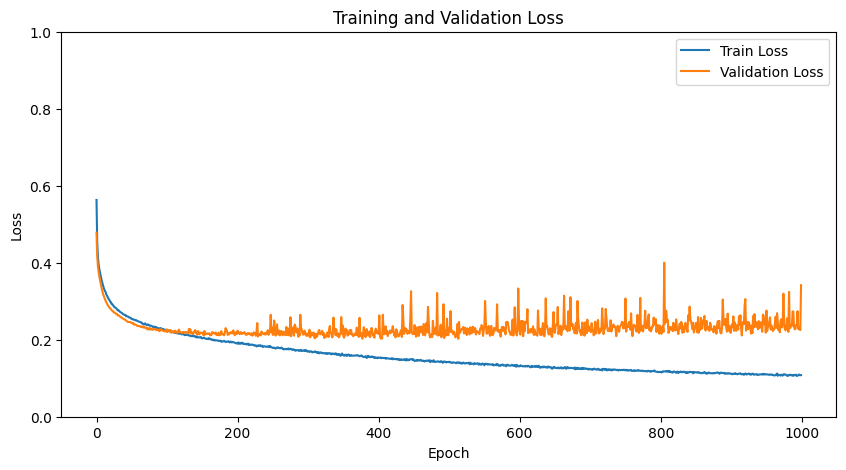

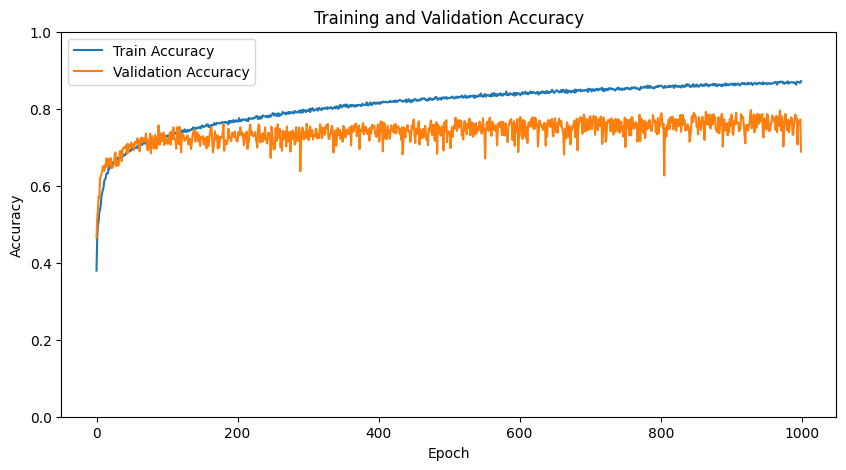

In [14]:
import matplotlib.pyplot as plt

# Get the training history
train_loss = history.history['loss']
train_acc = history.history['accuracy']
val_loss = history.history['val_loss']
val_acc = history.history['val_accuracy']

# Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.ylim([0, 1])
plt.show()

# Plot the training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.ylim([0, 1])
plt.show()

In [15]:
from keras.optimizers import Adam, RMSprop, SGD
from keras.layers import Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import numpy as np
import pandas as pd
import pickle

# 데이터셋 준비
train_df = pd.read_csv('../data/SisFall_train_L_20.csv')  # 훈련 파일
test_df = pd.read_csv('../data/SisFall_val_L_20.csv')  # 테스트 파일

X_train = []  # 훈련 입력 데이터
y_train = []  # 훈련 출력 데이터

X_test = []  # 테스트 입력 데이터
y_test = []  # 테스트 출력 데이터

# 4개의 레코드씩 묶어서 처리
for i in range(0, len(train_df) - 19, 20):
    # gx, gy, gz 값 가져오기
    gx_values = train_df.loc[i:i+19, 'gx'].values
    gy_values = train_df.loc[i:i+19, 'gy'].values
    gz_values = train_df.loc[i:i+19, 'gz'].values

    # 레이블 값 가져오기
    labels = train_df.loc[i:i+19, 'label'].values

    # 서로 다른 레이블이 포함된 경우 해당 시퀀스는 분석에서 제외
    if len(set(labels)) == 1:
        # 시퀀스로 변환하여 입력 데이터에 추가
        X_train.append(np.transpose([gx_values, gy_values, gz_values]))

        # 레이블 값 중복 제거하여 출력 데이터에 추가
        y_train.append(labels[0])

for i in range(0, len(test_df) - 19, 20):
    # gx, gy, gz 값 가져오기
    gx_values = test_df.loc[i:i+19, 'gx'].values
    gy_values = test_df.loc[i:i+19, 'gy'].values
    gz_values = test_df.loc[i:i+19, 'gz'].values

    # 레이블 값 가져오기
    labels = test_df.loc[i:i+19, 'label'].values

    # 서로 다른 레이블이 포함된 경우 해당 시퀀스는 분석에서 제외
    if len(set(labels)) == 1:
        # 시퀀스로 변환하여 입력 데이터에 추가
        X_test.append(np.transpose([gx_values, gy_values, gz_values]))

        # 레이블 값 중복 제거하여 출력 데이터에 추가
        y_test.append(labels[0])

# 입력 데이터와 출력 데이터를 넘파이 배열로 변환
X_train = np.array(X_train)
y_train = np.array(y_train)

X_test = np.array(X_test)
y_test = np.array(y_test)

# 출력 데이터를 One-Hot 인코딩
label_encoder = LabelEncoder()
integer_encoded_train = label_encoder.fit_transform(y_train)
integer_encoded_train = integer_encoded_train.reshape(len(integer_encoded_train), 1)
onehot_encoder_train = OneHotEncoder(sparse_output=False)
y_train = onehot_encoder_train.fit_transform(integer_encoded_train)

integer_encoded_test = label_encoder.transform(y_test)
integer_encoded_test = integer_encoded_test.reshape(len(integer_encoded_test), 1)
onehot_encoder_test = OneHotEncoder(sparse_output=False)
y_test = onehot_encoder_test.fit_transform(integer_encoded_test)

# CNN-LSTM 모델 정의
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(20, 3)))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.2))  # Dropout layer with 20% dropout rate
model.add(BatchNormalization())  # Batch normalization layer
model.add(LSTM(128))
model.add(Dense(5, activation='softmax'))

# 모델 컴파일 및 학습
model.compile(loss='binary_crossentropy', optimizer=SGD(learning_rate=0.01), metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=300, batch_size=32, validation_data=(X_test, y_test))

# 최상의 적합 모델의 가중치를 피클 파일로 저장
best_model_weights = model.get_weights()
pickle.dump(best_model_weights, open('../model/best_model_weights_cnn_lstm.pkl', 'wb'))

# 레이블 인코더의 클래스 정보를 저장
np.save('../model/label_encoder_classes_cnn_lstm.npy', label_encoder.classes_)

# 모델 저장
model.save('../model/loaded_model_cnn_lstm.h5')

Epoch 1/300
427/427 [==============================] - 5s 8ms/step - loss: 0.5731 - accuracy: 0.3567 - val_loss: 0.4882 - val_accuracy: 0.3875
Epoch 2/300
427/427 [==============================] - 3s 7ms/step - loss: 0.4602 - accuracy: 0.4164 - val_loss: 0.4205 - val_accuracy: 0.4477
Epoch 3/300
427/427 [==============================] - 3s 7ms/step - loss: 0.4192 - accuracy: 0.4662 - val_loss: 0.3935 - val_accuracy: 0.4944
Epoch 4/300
427/427 [==============================] - 3s 7ms/step - loss: 0.4007 - accuracy: 0.4903 - val_loss: 0.3781 - val_accuracy: 0.5313
Epoch 5/300
427/427 [==============================] - 3s 7ms/step - loss: 0.3880 - accuracy: 0.5083 - val_loss: 0.3664 - val_accuracy: 0.5628
Epoch 6/300
427/427 [==============================] - 3s 7ms/step - loss: 0.3778 - accuracy: 0.5321 - val_loss: 0.3556 - val_accuracy: 0.6335
Epoch 7/300
427/427 [==============================] - 3s 7ms/step - loss: 0.3680 - accuracy: 0.5467 - val_loss: 0.3450 - val_accuracy: 0.6184

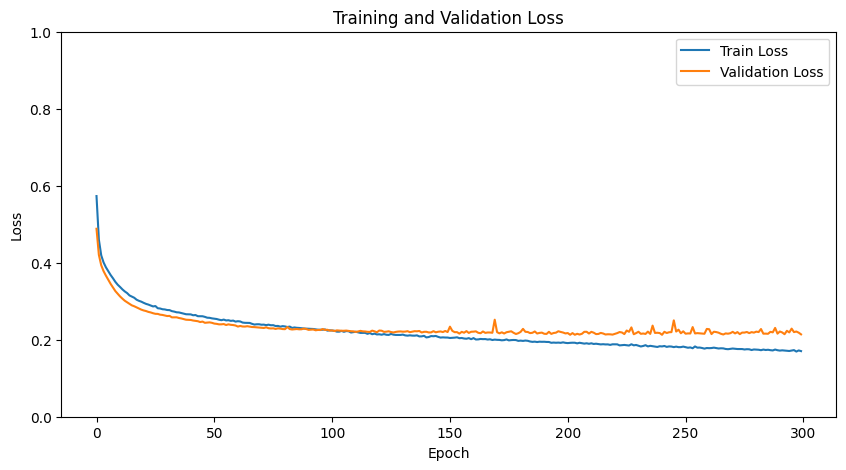

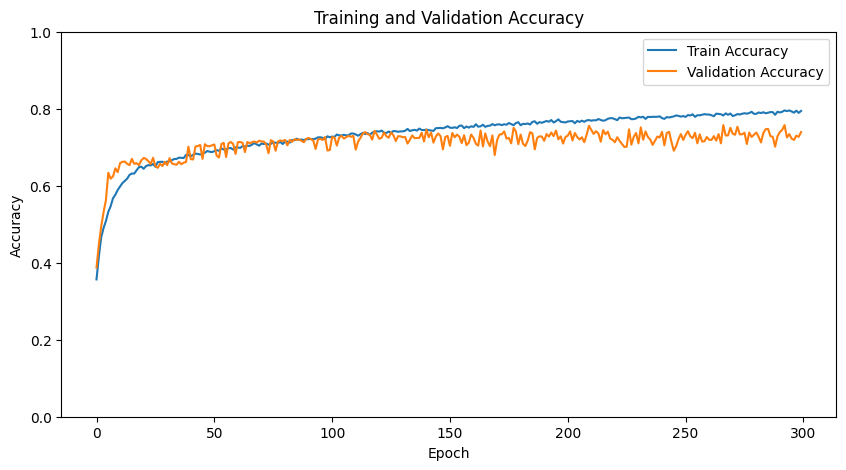

In [16]:
import matplotlib.pyplot as plt

# Get the training history
train_loss = history.history['loss']
train_acc = history.history['accuracy']
val_loss = history.history['val_loss']
val_acc = history.history['val_accuracy']

# Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.ylim([0, 1])
plt.show()

# Plot the training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.ylim([0, 1])
plt.show()

In [20]:
from keras.optimizers import Adam, RMSprop, SGD
from keras.layers import Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import numpy as np
import pandas as pd
import pickle

# 데이터셋 준비
train_df = pd.read_csv('../data/SisFall_train_L_20.csv')  # 훈련 파일
test_df = pd.read_csv('../data/SisFall_val_L_20.csv')  # 테스트 파일

X_train = []  # 훈련 입력 데이터
y_train = []  # 훈련 출력 데이터

X_test = []  # 테스트 입력 데이터
y_test = []  # 테스트 출력 데이터

# 4개의 레코드씩 묶어서 처리
for i in range(0, len(train_df) - 19, 20):
    # gx, gy, gz 값 가져오기
    gx_values = train_df.loc[i:i+19, 'gx'].values
    gy_values = train_df.loc[i:i+19, 'gy'].values
    gz_values = train_df.loc[i:i+19, 'gz'].values

    # 레이블 값 가져오기
    labels = train_df.loc[i:i+19, 'label'].values

    # 서로 다른 레이블이 포함된 경우 해당 시퀀스는 분석에서 제외
    if len(set(labels)) == 1:
        # 시퀀스로 변환하여 입력 데이터에 추가
        X_train.append(np.transpose([gx_values, gy_values, gz_values]))

        # 레이블 값 중복 제거하여 출력 데이터에 추가
        y_train.append(labels[0])

for i in range(0, len(test_df) - 19, 20):
    # gx, gy, gz 값 가져오기
    gx_values = test_df.loc[i:i+19, 'gx'].values
    gy_values = test_df.loc[i:i+19, 'gy'].values
    gz_values = test_df.loc[i:i+19, 'gz'].values

    # 레이블 값 가져오기
    labels = test_df.loc[i:i+19, 'label'].values

    # 서로 다른 레이블이 포함된 경우 해당 시퀀스는 분석에서 제외
    if len(set(labels)) == 1:
        # 시퀀스로 변환하여 입력 데이터에 추가
        X_test.append(np.transpose([gx_values, gy_values, gz_values]))

        # 레이블 값 중복 제거하여 출력 데이터에 추가
        y_test.append(labels[0])

# 입력 데이터와 출력 데이터를 넘파이 배열로 변환
X_train = np.array(X_train)
y_train = np.array(y_train)

X_test = np.array(X_test)
y_test = np.array(y_test)

# 출력 데이터를 One-Hot 인코딩
label_encoder = LabelEncoder()
integer_encoded_train = label_encoder.fit_transform(y_train)
integer_encoded_train = integer_encoded_train.reshape(len(integer_encoded_train), 1)
onehot_encoder_train = OneHotEncoder(sparse_output=False)
y_train = onehot_encoder_train.fit_transform(integer_encoded_train)

integer_encoded_test = label_encoder.transform(y_test)
integer_encoded_test = integer_encoded_test.reshape(len(integer_encoded_test), 1)
onehot_encoder_test = OneHotEncoder(sparse_output=False)
y_test = onehot_encoder_test.fit_transform(integer_encoded_test)

# CNN-LSTM 모델 정의
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(20, 3)))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.2))  # Dropout layer with 20% dropout rate
model.add(BatchNormalization())  # Batch normalization layer
model.add(LSTM(128))
model.add(Dense(5, activation='softmax'))

# 모델 컴파일 및 학습
model.compile(loss='binary_crossentropy', optimizer=SGD(learning_rate=0.01), metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=450, batch_size=32, validation_data=(X_test, y_test))

# 최상의 적합 모델의 가중치를 피클 파일로 저장
best_model_weights = model.get_weights()
pickle.dump(best_model_weights, open('../model/best_model_weights_cnn_lstm_adam.pkl', 'wb'))

# 레이블 인코더의 클래스 정보를 저장
np.save('../model/label_encoder_classes_cnn_lstm_adam.npy', label_encoder.classes_)

# 모델 저장
model.save('../model/loaded_model_cnn_lstm_adam.h5')

Epoch 1/450
427/427 [==============================] - 6s 9ms/step - loss: 0.5684 - accuracy: 0.3785 - val_loss: 0.4857 - val_accuracy: 0.4044
Epoch 2/450
427/427 [==============================] - 3s 7ms/step - loss: 0.4597 - accuracy: 0.4122 - val_loss: 0.4218 - val_accuracy: 0.4313
Epoch 3/450
427/427 [==============================] - 3s 7ms/step - loss: 0.4203 - accuracy: 0.4421 - val_loss: 0.3949 - val_accuracy: 0.4763
Epoch 4/450
427/427 [==============================] - 3s 7ms/step - loss: 0.4008 - accuracy: 0.4815 - val_loss: 0.3791 - val_accuracy: 0.5196
Epoch 5/450
427/427 [==============================] - 3s 7ms/step - loss: 0.3867 - accuracy: 0.5132 - val_loss: 0.3668 - val_accuracy: 0.5593
Epoch 6/450
427/427 [==============================] - 3s 7ms/step - loss: 0.3754 - accuracy: 0.5454 - val_loss: 0.3552 - val_accuracy: 0.6049
Epoch 7/450
427/427 [==============================] - 3s 7ms/step - loss: 0.3664 - accuracy: 0.5622 - val_loss: 0.3446 - val_accuracy: 0.6154

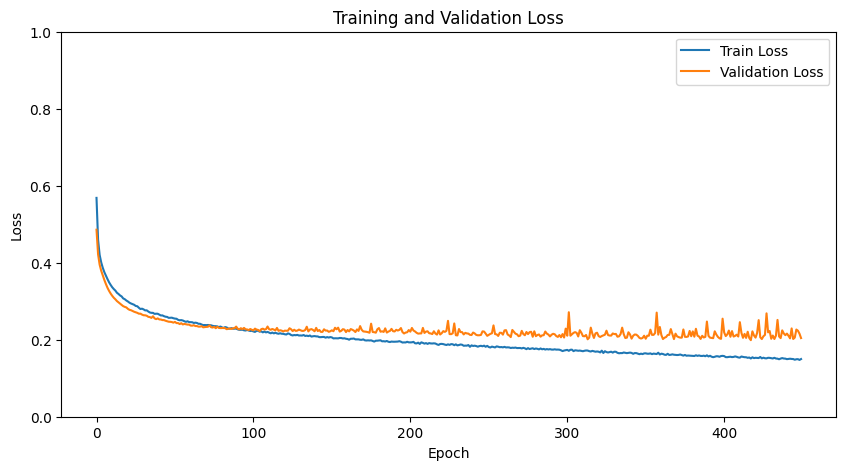

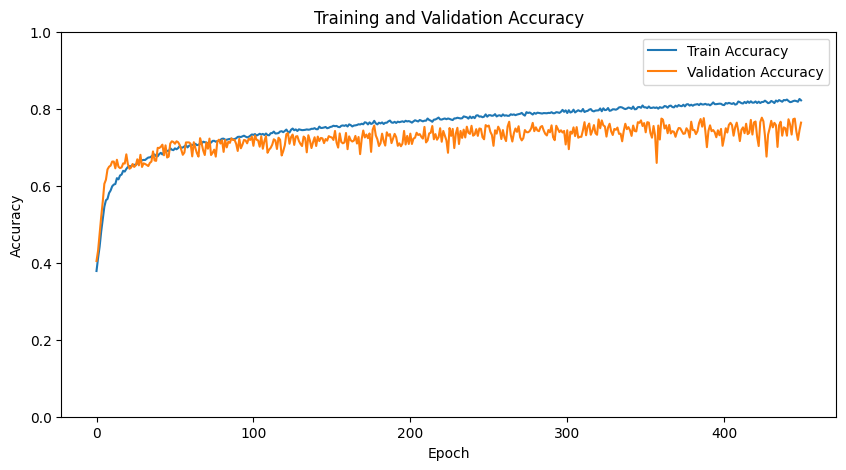

In [21]:
import matplotlib.pyplot as plt

# Get the training history
train_loss = history.history['loss']
train_acc = history.history['accuracy']
val_loss = history.history['val_loss']
val_acc = history.history['val_accuracy']

# Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.ylim([0, 1])
plt.show()

# Plot the training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.ylim([0, 1])
plt.show()

In [23]:
from keras.optimizers import Adam, RMSprop, SGD
from keras.layers import Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import numpy as np
import pandas as pd
import pickle

# 데이터셋 준비
train_df = pd.read_csv('../data/SisFall_train_L_20.csv')  # 훈련 파일
test_df = pd.read_csv('../data/SisFall_val_L_20.csv')  # 테스트 파일

X_train = []  # 훈련 입력 데이터
y_train = []  # 훈련 출력 데이터

X_test = []  # 테스트 입력 데이터
y_test = []  # 테스트 출력 데이터

# 4개의 레코드씩 묶어서 처리
for i in range(0, len(train_df) - 19, 20):
    # gx, gy, gz 값 가져오기
    gx_values = train_df.loc[i:i+19, 'gx'].values
    gy_values = train_df.loc[i:i+19, 'gy'].values
    gz_values = train_df.loc[i:i+19, 'gz'].values
    ax_values = train_df.loc[i:i+19, 'ax'].values
    ay_values = train_df.loc[i:i+19, 'ay'].values
    az_values = train_df.loc[i:i+19, 'az'].values

    # 레이블 값 가져오기
    labels = train_df.loc[i:i+19, 'label'].values

    # 서로 다른 레이블이 포함된 경우 해당 시퀀스는 분석에서 제외
    if len(set(labels)) == 1:
        # 시퀀스로 변환하여 입력 데이터에 추가
        X_train.append(np.transpose([gx_values, gy_values, gz_values]))

        # 레이블 값 중복 제거하여 출력 데이터에 추가
        y_train.append(labels[0])

for i in range(0, len(test_df) - 19, 20):
    # gx, gy, gz 값 가져오기
    gx_values = test_df.loc[i:i+19, 'gx'].values
    gy_values = test_df.loc[i:i+19, 'gy'].values
    gz_values = test_df.loc[i:i+19, 'gz'].values
    ax_values = test_df.loc[i:i+19, 'ax'].values
    ay_values = test_df.loc[i:i+19, 'ay'].values
    az_values = test_df.loc[i:i+19, 'az'].values

    # 레이블 값 가져오기
    labels = test_df.loc[i:i+19, 'label'].values

    # 서로 다른 레이블이 포함된 경우 해당 시퀀스는 분석에서 제외
    if len(set(labels)) == 1:
        # 시퀀스로 변환하여 입력 데이터에 추가
        X_test.append(np.transpose([gx_values, gy_values, gz_values]))

        # 레이블 값 중복 제거하여 출력 데이터에 추가
        y_test.append(labels[0])

# 입력 데이터와 출력 데이터를 넘파이 배열로 변환
X_train = np.array(X_train)
y_train = np.array(y_train)

X_test = np.array(X_test)
y_test = np.array(y_test)

# 출력 데이터를 One-Hot 인코딩
label_encoder = LabelEncoder()
integer_encoded_train = label_encoder.fit_transform(y_train)
integer_encoded_train = integer_encoded_train.reshape(len(integer_encoded_train), 1)
onehot_encoder_train = OneHotEncoder(sparse_output=False)
y_train = onehot_encoder_train.fit_transform(integer_encoded_train)

integer_encoded_test = label_encoder.transform(y_test)
integer_encoded_test = integer_encoded_test.reshape(len(integer_encoded_test), 1)
onehot_encoder_test = OneHotEncoder(sparse_output=False)
y_test = onehot_encoder_test.fit_transform(integer_encoded_test)

# CNN-LSTM 모델 정의
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=6, activation='relu', input_shape=(20, 3)))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.2))  # Dropout layer with 20% dropout rate
model.add(BatchNormalization())  # Batch normalization layer
model.add(LSTM(128))
model.add(Dense(5, activation='softmax'))

# 모델 컴파일 및 학습
model.compile(loss='binary_crossentropy', optimizer=SGD(learning_rate=0.01), metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=450, batch_size=32, validation_data=(X_test, y_test))

# 최상의 적합 모델의 가중치를 피클 파일로 저장
best_model_weights = model.get_weights()
pickle.dump(best_model_weights, open('../model/best_model_weights_cnn_lstm_adam.pkl', 'wb'))

# 레이블 인코더의 클래스 정보를 저장
np.save('../model/label_encoder_classes_cnn_lstm_adam.npy', label_encoder.classes_)

# 모델 저장
model.save('../model/loaded_model_cnn_lstm_adam.h5')

Epoch 1/450
427/427 [==============================] - 6s 10ms/step - loss: 0.5761 - accuracy: 0.3616 - val_loss: 0.4969 - val_accuracy: 0.4208
Epoch 2/450
427/427 [==============================] - 3s 7ms/step - loss: 0.4697 - accuracy: 0.4236 - val_loss: 0.4318 - val_accuracy: 0.4401
Epoch 3/450
427/427 [==============================] - 3s 7ms/step - loss: 0.4272 - accuracy: 0.4531 - val_loss: 0.4015 - val_accuracy: 0.4956
Epoch 4/450
427/427 [==============================] - 3s 7ms/step - loss: 0.4059 - accuracy: 0.4862 - val_loss: 0.3833 - val_accuracy: 0.5371
Epoch 5/450
427/427 [==============================] - 3s 7ms/step - loss: 0.3909 - accuracy: 0.5176 - val_loss: 0.3690 - val_accuracy: 0.5675
Epoch 6/450
427/427 [==============================] - 3s 7ms/step - loss: 0.3777 - accuracy: 0.5350 - val_loss: 0.3572 - val_accuracy: 0.5786
Epoch 7/450
427/427 [==============================] - 3s 7ms/step - loss: 0.3684 - accuracy: 0.5453 - val_loss: 0.3457 - val_accuracy: 0.596

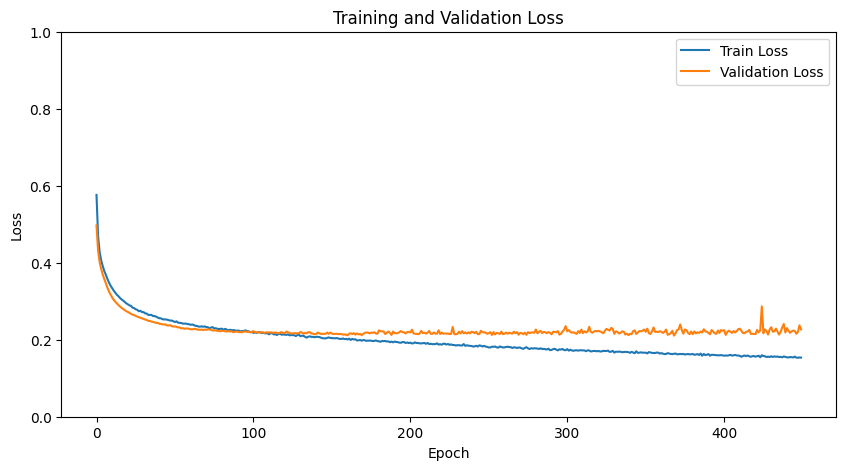

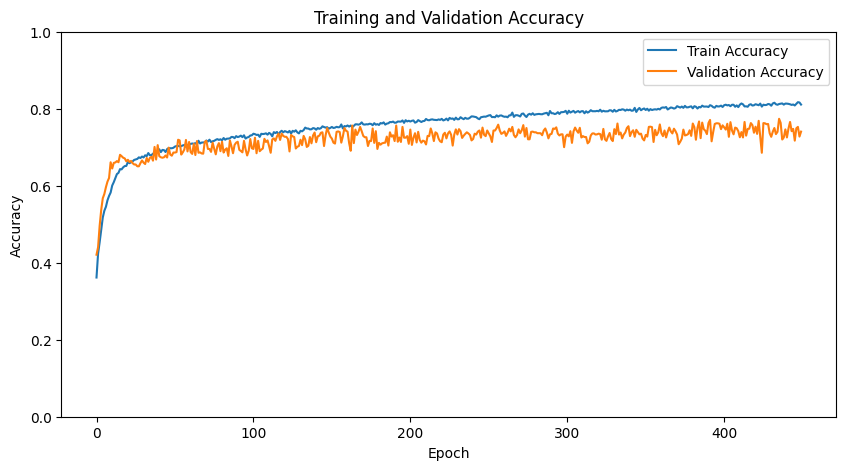

In [24]:
import matplotlib.pyplot as plt

# Get the training history
train_loss = history.history['loss']
train_acc = history.history['accuracy']
val_loss = history.history['val_loss']
val_acc = history.history['val_accuracy']

# Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.ylim([0, 1])
plt.show()

# Plot the training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.ylim([0, 1])
plt.show()

In [31]:
import keras

# 테스트 데이터 로드
test_df = pd.read_csv('../data/SisFall_test_L_19.csv')

X_test = []  # 테스트 입력 데이터
y_test = []  # 테스트 출력 데이터

# 4개의 레코드씩 묶어서 처리
for i in range(0, len(test_df) - 19, 20):
    # gx, gy, gz 값 가져오기
    gx_values = test_df.loc[i:i+19, 'gx'].values
    gy_values = test_df.loc[i:i+19, 'gy'].values
    gz_values = test_df.loc[i:i+19, 'gz'].values
    ax_values = test_df.loc[i:i+19, 'ax'].values
    ay_values = test_df.loc[i:i+19, 'ay'].values
    az_values = test_df.loc[i:i+19, 'az'].values

    # 레이블 값 가져오기
    labels = test_df.loc[i:i+19, 'label'].values

    # 서로 다른 레이블이 포함된 경우 해당 시퀀스는 분석에서 제외
    if len(set(labels)) == 1:
        # 시퀀스로 변환하여 입력 데이터에 추가
        X_test.append(np.transpose([gx_values, gy_values, gz_values]))

        # 레이블 값 중복 제거하여 출력 데이터에 추가
        y_test.append(labels[0])

# 입력 데이터와 출력 데이터를 넘파이 배열로 변환
X_test = np.array(X_test)
y_test = np.array(y_test)

# 출력 데이터를 One-Hot 인코딩
integer_encoded_test = label_encoder.transform(y_test)
integer_encoded_test = integer_encoded_test.reshape(len(integer_encoded_test), 1)
onehot_encoder_test = OneHotEncoder(sparse_output=False)
y_test = onehot_encoder_test.fit_transform(integer_encoded_test)

# 모델 로드
model = keras.models.load_model('../model/loaded_model_cnn_lstm_adam.h5')

# 테스트 데이터에 대한 예측 수행
predictions = model.predict(X_test)

# 예측 결과를 클래스로 변환
predicted_labels = np.argmax(predictions, axis=1)

# 테스트 데이터 정확도 계산
accuracy = np.mean(predicted_labels == np.argmax(y_test, axis=1))
print("테스트 데이터 정확도:", accuracy)

91/91 [==============================] - 1s 2ms/step
테스트 데이터 정확도: 0.7516317416695294


In [32]:
from keras.optimizers import Adam, RMSprop, SGD
from keras.layers import Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import numpy as np
import pandas as pd
import pickle

# 데이터셋 준비
train_df = pd.read_csv('../data/SisFall_train_L.csv')  # 훈련 파일
test_df = pd.read_csv('../data/SisFall_val_L.csv')  # 테스트 파일

X_train = []  # 훈련 입력 데이터
y_train = []  # 훈련 출력 데이터

X_test = []  # 테스트 입력 데이터
y_test = []  # 테스트 출력 데이터

# 4개의 레코드씩 묶어서 처리
for i in range(0, len(train_df) - 39, 40):
    # gx, gy, gz 값 가져오기
    gx_values = train_df.loc[i:i+39, 'gx'].values
    gy_values = train_df.loc[i:i+39, 'gy'].values
    gz_values = train_df.loc[i:i+39, 'gz'].values
    ax_values = train_df.loc[i:i+39, 'ax'].values
    ay_values = train_df.loc[i:i+39, 'ay'].values
    az_values = train_df.loc[i:i+39, 'az'].values

    # 레이블 값 가져오기
    labels = train_df.loc[i:i+39, 'label'].values

    # 서로 다른 레이블이 포함된 경우 해당 시퀀스는 분석에서 제외
    if len(set(labels)) == 1:
        # 시퀀스로 변환하여 입력 데이터에 추가
        X_train.append(np.transpose([gx_values, gy_values, gz_values]))

        # 레이블 값 중복 제거하여 출력 데이터에 추가
        y_train.append(labels[0])

for i in range(0, len(test_df) - 39, 40):
    # gx, gy, gz 값 가져오기
    gx_values = test_df.loc[i:i+39, 'gx'].values
    gy_values = test_df.loc[i:i+39, 'gy'].values
    gz_values = test_df.loc[i:i+39, 'gz'].values
    ax_values = test_df.loc[i:i+39, 'ax'].values
    ay_values = test_df.loc[i:i+39, 'ay'].values
    az_values = test_df.loc[i:i+39, 'az'].values

    # 레이블 값 가져오기
    labels = test_df.loc[i:i+39, 'label'].values

    # 서로 다른 레이블이 포함된 경우 해당 시퀀스는 분석에서 제외
    if len(set(labels)) == 1:
        # 시퀀스로 변환하여 입력 데이터에 추가
        X_test.append(np.transpose([gx_values, gy_values, gz_values]))

        # 레이블 값 중복 제거하여 출력 데이터에 추가
        y_test.append(labels[0])

# 입력 데이터와 출력 데이터를 넘파이 배열로 변환
X_train = np.array(X_train)
y_train = np.array(y_train)

X_test = np.array(X_test)
y_test = np.array(y_test)

# 출력 데이터를 One-Hot 인코딩
label_encoder = LabelEncoder()
integer_encoded_train = label_encoder.fit_transform(y_train)
integer_encoded_train = integer_encoded_train.reshape(len(integer_encoded_train), 1)
onehot_encoder_train = OneHotEncoder(sparse_output=False)
y_train = onehot_encoder_train.fit_transform(integer_encoded_train)

integer_encoded_test = label_encoder.transform(y_test)
integer_encoded_test = integer_encoded_test.reshape(len(integer_encoded_test), 1)
onehot_encoder_test = OneHotEncoder(sparse_output=False)
y_test = onehot_encoder_test.fit_transform(integer_encoded_test)

# CNN-LSTM 모델 정의
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=6, activation='relu', input_shape=(40, 3)))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.2))  # Dropout layer with 20% dropout rate
model.add(BatchNormalization())  # Batch normalization layer
model.add(LSTM(128))
model.add(Dense(5, activation='softmax'))

# 모델 컴파일 및 학습
model.compile(loss='binary_crossentropy', optimizer=SGD(learning_rate=0.01), metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=450, batch_size=32, validation_data=(X_test, y_test))

# 최상의 적합 모델의 가중치를 피클 파일로 저장
best_model_weights = model.get_weights()
pickle.dump(best_model_weights, open('../model/best_model_weights_cnn_lstm_adam_40.pkl', 'wb'))

# 레이블 인코더의 클래스 정보를 저장
np.save('../model/label_encoder_classes_cnn_lstm_adam_40.npy', label_encoder.classes_)

# 모델 저장
model.save('../model/loaded_model_cnn_lstm_adam_40.h5')

Epoch 1/450
427/427 [==============================] - 8s 14ms/step - loss: 0.5514 - accuracy: 0.4124 - val_loss: 0.4584 - val_accuracy: 0.4874
Epoch 2/450
427/427 [==============================] - 5s 12ms/step - loss: 0.4352 - accuracy: 0.4956 - val_loss: 0.3960 - val_accuracy: 0.5243
Epoch 3/450
427/427 [==============================] - 5s 12ms/step - loss: 0.3989 - accuracy: 0.5093 - val_loss: 0.3714 - val_accuracy: 0.5476
Epoch 4/450
427/427 [==============================] - 5s 12ms/step - loss: 0.3797 - accuracy: 0.5344 - val_loss: 0.3537 - val_accuracy: 0.6002
Epoch 5/450
427/427 [==============================] - 5s 12ms/step - loss: 0.3643 - accuracy: 0.5628 - val_loss: 0.3375 - val_accuracy: 0.6318
Epoch 6/450
427/427 [==============================] - 5s 13ms/step - loss: 0.3512 - accuracy: 0.5774 - val_loss: 0.3240 - val_accuracy: 0.6189
Epoch 7/450
427/427 [==============================] - 5s 12ms/step - loss: 0.3393 - accuracy: 0.5984 - val_loss: 0.3130 - val_accuracy:

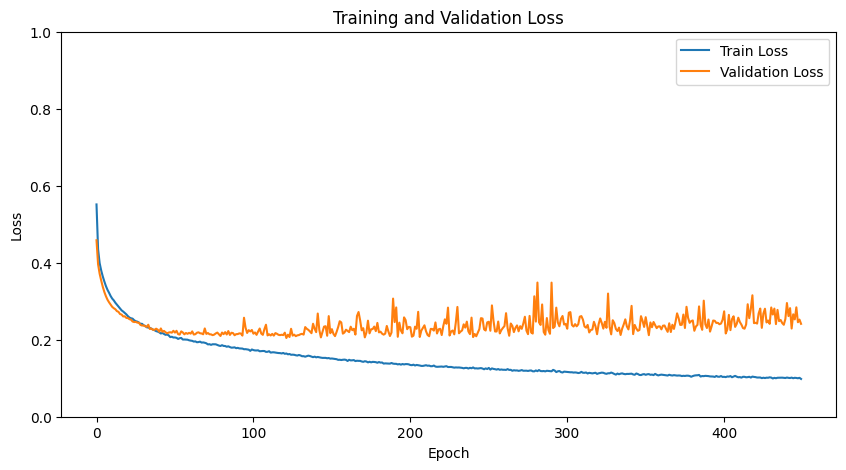

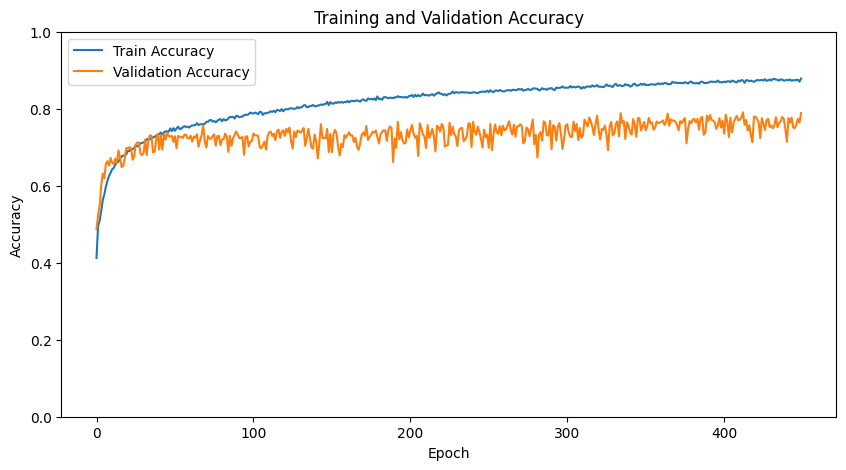

In [33]:
import matplotlib.pyplot as plt

# Get the training history
train_loss = history.history['loss']
train_acc = history.history['accuracy']
val_loss = history.history['val_loss']
val_acc = history.history['val_accuracy']

# Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.ylim([0, 1])
plt.show()

# Plot the training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.ylim([0, 1])
plt.show()

In [4]:
from keras.optimizers import Adam, RMSprop, SGD
from keras.layers import Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import numpy as np
import pandas as pd
import pickle

# 데이터셋 준비
train_df = pd.read_csv('../data/SisFall_train_L_20_adl.csv')  # 훈련 파일
test_df = pd.read_csv('../data/SisFall_val_L_20_adl.csv')  # 테스트 파일

X_train = []  # 훈련 입력 데이터
y_train = []  # 훈련 출력 데이터

X_test = []  # 테스트 입력 데이터
y_test = []  # 테스트 출력 데이터

# 4개의 레코드씩 묶어서 처리
for i in range(0, len(train_df) - 19, 20):
    # gx, gy, gz 값 가져오기
    gx_values = train_df.loc[i:i+19, 'gx'].values
    gy_values = train_df.loc[i:i+19, 'gy'].values
    gz_values = train_df.loc[i:i+19, 'gz'].values
    ax_values = train_df.loc[i:i+19, 'ax'].values
    ay_values = train_df.loc[i:i+19, 'ay'].values
    az_values = train_df.loc[i:i+19, 'az'].values

    # 레이블 값 가져오기
    labels = train_df.loc[i:i+19, 'label'].values

    # 서로 다른 레이블이 포함된 경우 해당 시퀀스는 분석에서 제외
    if len(set(labels)) == 1:
        # 시퀀스로 변환하여 입력 데이터에 추가
        X_train.append(np.transpose([gx_values, gy_values, gz_values]))

        # 레이블 값 중복 제거하여 출력 데이터에 추가
        y_train.append(labels[0])

for i in range(0, len(test_df) - 19, 20):
    # gx, gy, gz 값 가져오기
    gx_values = test_df.loc[i:i+19, 'gx'].values
    gy_values = test_df.loc[i:i+19, 'gy'].values
    gz_values = test_df.loc[i:i+19, 'gz'].values
    ax_values = test_df.loc[i:i+19, 'ax'].values
    ay_values = test_df.loc[i:i+19, 'ay'].values
    az_values = test_df.loc[i:i+19, 'az'].values

    # 레이블 값 가져오기
    labels = test_df.loc[i:i+19, 'label'].values

    # 서로 다른 레이블이 포함된 경우 해당 시퀀스는 분석에서 제외
    if len(set(labels)) == 1:
        # 시퀀스로 변환하여 입력 데이터에 추가
        X_test.append(np.transpose([gx_values, gy_values, gz_values]))

        # 레이블 값 중복 제거하여 출력 데이터에 추가
        y_test.append(labels[0])

# 입력 데이터와 출력 데이터를 넘파이 배열로 변환
X_train = np.array(X_train)
y_train = np.array(y_train)

X_test = np.array(X_test)
y_test = np.array(y_test)

# 출력 데이터를 One-Hot 인코딩
label_encoder = LabelEncoder()
integer_encoded_train = label_encoder.fit_transform(y_train)
integer_encoded_train = integer_encoded_train.reshape(len(integer_encoded_train), 1)
onehot_encoder_train = OneHotEncoder(sparse_output=False)
y_train = onehot_encoder_train.fit_transform(integer_encoded_train)

integer_encoded_test = label_encoder.transform(y_test)
integer_encoded_test = integer_encoded_test.reshape(len(integer_encoded_test), 1)
onehot_encoder_test = OneHotEncoder(sparse_output=False)
y_test = onehot_encoder_test.fit_transform(integer_encoded_test)

# CNN-LSTM 모델 정의
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=6, activation='relu', input_shape=(20, 3)))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.2))  # Dropout layer with 20% dropout rate
model.add(BatchNormalization())  # Batch normalization layer
model.add(LSTM(128))
model.add(Dense(2, activation='softmax'))

# 모델 컴파일 및 학습
model.compile(loss='binary_crossentropy', optimizer=SGD(learning_rate=0.01), metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=450, batch_size=32, validation_data=(X_test, y_test))

# 최상의 적합 모델의 가중치를 피클 파일로 저장
best_model_weights = model.get_weights()
pickle.dump(best_model_weights, open('../model/best_model_weights_cnn_lstm_adam.pkl', 'wb'))

# 레이블 인코더의 클래스 정보를 저장
np.save('../model/label_encoder_classes_cnn_lstm_adam.npy', label_encoder.classes_)

# 모델 저장
model.save('../model/loaded_model_cnn_lstm_adam.h5')

Epoch 1/450
429/429 [==============================] - 4s 6ms/step - loss: 0.5689 - accuracy: 0.7698 - val_loss: 0.4700 - val_accuracy: 0.8251
Epoch 2/450
429/429 [==============================] - 2s 5ms/step - loss: 0.4896 - accuracy: 0.7938 - val_loss: 0.4352 - val_accuracy: 0.8251
Epoch 3/450
429/429 [==============================] - 2s 5ms/step - loss: 0.4735 - accuracy: 0.7938 - val_loss: 0.4229 - val_accuracy: 0.8251
Epoch 4/450
429/429 [==============================] - 2s 5ms/step - loss: 0.4681 - accuracy: 0.7938 - val_loss: 0.4163 - val_accuracy: 0.8251
Epoch 5/450
429/429 [==============================] - 2s 5ms/step - loss: 0.4608 - accuracy: 0.7941 - val_loss: 0.4104 - val_accuracy: 0.8257
Epoch 6/450
429/429 [==============================] - 2s 5ms/step - loss: 0.4562 - accuracy: 0.7952 - val_loss: 0.4051 - val_accuracy: 0.8274
Epoch 7/450
429/429 [==============================] - 2s 5ms/step - loss: 0.4510 - accuracy: 0.7962 - val_loss: 0.4006 - val_accuracy: 0.8274

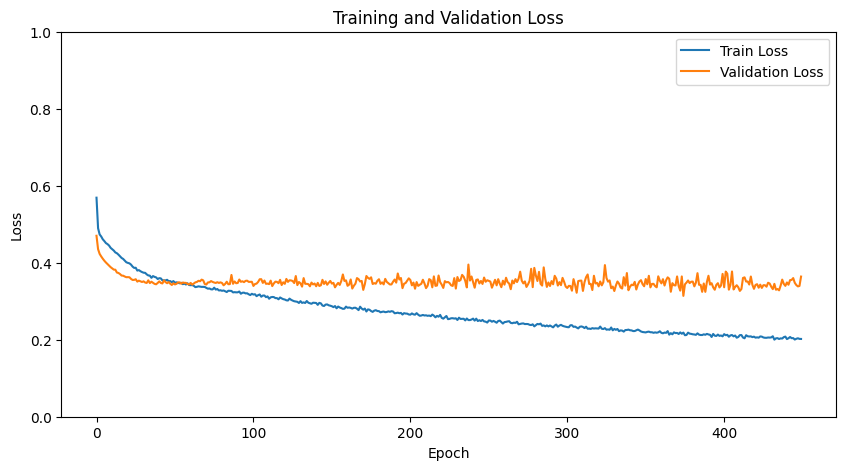

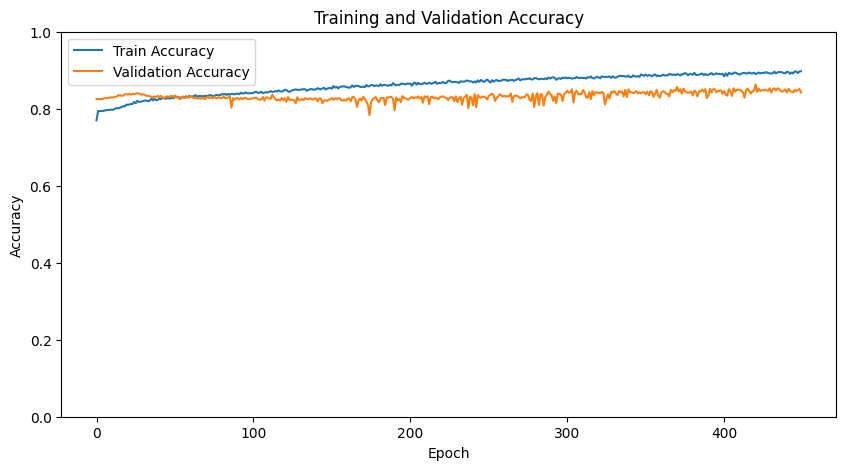

In [5]:
import matplotlib.pyplot as plt

# Get the training history
train_loss = history.history['loss']
train_acc = history.history['accuracy']
val_loss = history.history['val_loss']
val_acc = history.history['val_accuracy']

# Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.ylim([0, 1])
plt.show()

# Plot the training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.ylim([0, 1])
plt.show()

In [6]:
from keras.optimizers import Adam, RMSprop, SGD
from keras.layers import Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import numpy as np
import pandas as pd
import pickle

# 데이터셋 준비
train_df = pd.read_csv('../data/SisFall_train_L_20_adl.csv')  # 훈련 파일
test_df = pd.read_csv('../data/SisFall_val_L_20_adl.csv')  # 테스트 파일

X_train = []  # 훈련 입력 데이터
y_train = []  # 훈련 출력 데이터

X_test = []  # 테스트 입력 데이터
y_test = []  # 테스트 출력 데이터

# 4개의 레코드씩 묶어서 처리
for i in range(0, len(train_df) - 19, 20):
    # gx, gy, gz 값 가져오기
    gx_values = train_df.loc[i:i+19, 'gx'].values
    gy_values = train_df.loc[i:i+19, 'gy'].values
    gz_values = train_df.loc[i:i+19, 'gz'].values
    ax_values = train_df.loc[i:i+19, 'ax'].values
    ay_values = train_df.loc[i:i+19, 'ay'].values
    az_values = train_df.loc[i:i+19, 'az'].values

    # 레이블 값 가져오기
    labels = train_df.loc[i:i+19, 'label'].values

    # 서로 다른 레이블이 포함된 경우 해당 시퀀스는 분석에서 제외
    if len(set(labels)) == 1:
        # 시퀀스로 변환하여 입력 데이터에 추가
        X_train.append(np.transpose([gx_values, gy_values, gz_values]))

        # 레이블 값 중복 제거하여 출력 데이터에 추가
        y_train.append(labels[0])

for i in range(0, len(test_df) - 19, 20):
    # gx, gy, gz 값 가져오기
    gx_values = test_df.loc[i:i+19, 'gx'].values
    gy_values = test_df.loc[i:i+19, 'gy'].values
    gz_values = test_df.loc[i:i+19, 'gz'].values
    ax_values = test_df.loc[i:i+19, 'ax'].values
    ay_values = test_df.loc[i:i+19, 'ay'].values
    az_values = test_df.loc[i:i+19, 'az'].values

    # 레이블 값 가져오기
    labels = test_df.loc[i:i+19, 'label'].values

    # 서로 다른 레이블이 포함된 경우 해당 시퀀스는 분석에서 제외
    if len(set(labels)) == 1:
        # 시퀀스로 변환하여 입력 데이터에 추가
        X_test.append(np.transpose([gx_values, gy_values, gz_values]))

        # 레이블 값 중복 제거하여 출력 데이터에 추가
        y_test.append(labels[0])

# 입력 데이터와 출력 데이터를 넘파이 배열로 변환
X_train = np.array(X_train)
y_train = np.array(y_train)

X_test = np.array(X_test)
y_test = np.array(y_test)

# 출력 데이터를 One-Hot 인코딩
label_encoder = LabelEncoder()
integer_encoded_train = label_encoder.fit_transform(y_train)
integer_encoded_train = integer_encoded_train.reshape(len(integer_encoded_train), 1)
onehot_encoder_train = OneHotEncoder(sparse_output=False)
y_train = onehot_encoder_train.fit_transform(integer_encoded_train)

integer_encoded_test = label_encoder.transform(y_test)
integer_encoded_test = integer_encoded_test.reshape(len(integer_encoded_test), 1)
onehot_encoder_test = OneHotEncoder(sparse_output=False)
y_test = onehot_encoder_test.fit_transform(integer_encoded_test)

# CNN-LSTM 모델 정의
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=6, activation='relu', input_shape=(20, 3)))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.2))  # Dropout layer with 20% dropout rate
model.add(BatchNormalization())  # Batch normalization layer
model.add(LSTM(128))
model.add(Dense(2, activation='softmax'))

# 모델 컴파일 및 학습
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=450, batch_size=32, validation_data=(X_test, y_test))

# 최상의 적합 모델의 가중치를 피클 파일로 저장
best_model_weights = model.get_weights()
pickle.dump(best_model_weights, open('../model/best_model_weights_cnn_lstm_adam.pkl', 'wb'))

# 레이블 인코더의 클래스 정보를 저장
np.save('../model/label_encoder_classes_cnn_lstm_adam.npy', label_encoder.classes_)

# 모델 저장
model.save('../model/loaded_model_cnn_lstm_adam.h5')

Epoch 1/450
429/429 [==============================] - 5s 6ms/step - loss: 0.4416 - accuracy: 0.7999 - val_loss: 0.3603 - val_accuracy: 0.8321
Epoch 2/450
429/429 [==============================] - 2s 5ms/step - loss: 0.3782 - accuracy: 0.8190 - val_loss: 0.3485 - val_accuracy: 0.8297
Epoch 3/450
429/429 [==============================] - 2s 5ms/step - loss: 0.3630 - accuracy: 0.8254 - val_loss: 0.3397 - val_accuracy: 0.8350
Epoch 4/450
429/429 [==============================] - 2s 5ms/step - loss: 0.3405 - accuracy: 0.8336 - val_loss: 0.3652 - val_accuracy: 0.8216
Epoch 5/450
429/429 [==============================] - 2s 5ms/step - loss: 0.3308 - accuracy: 0.8387 - val_loss: 0.3652 - val_accuracy: 0.8181
Epoch 6/450
429/429 [==============================] - 2s 5ms/step - loss: 0.3219 - accuracy: 0.8397 - val_loss: 0.3646 - val_accuracy: 0.8192
Epoch 7/450
429/429 [==============================] - 2s 5ms/step - loss: 0.3062 - accuracy: 0.8472 - val_loss: 0.3685 - val_accuracy: 0.8268

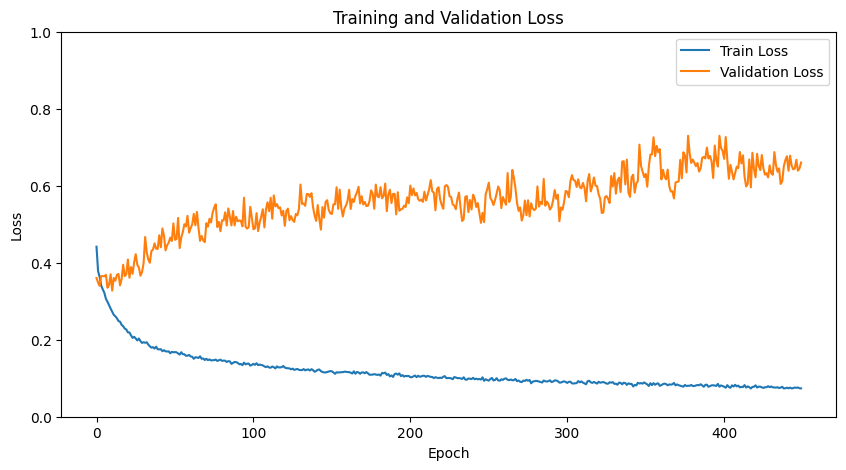

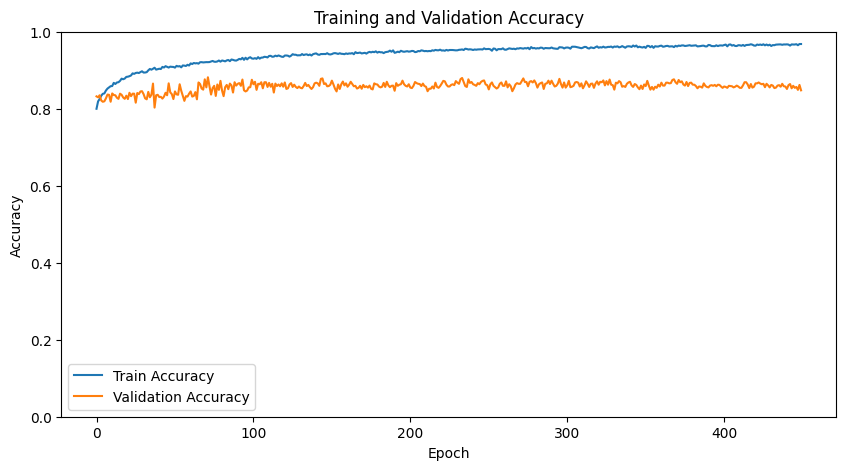

In [7]:
import matplotlib.pyplot as plt

# Get the training history
train_loss = history.history['loss']
train_acc = history.history['accuracy']
val_loss = history.history['val_loss']
val_acc = history.history['val_accuracy']

# Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.ylim([0, 1])
plt.show()

# Plot the training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.ylim([0, 1])
plt.show()

In [1]:
from keras.optimizers import Adam, RMSprop, SGD
from keras.layers import Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import f1_score
import numpy as np
import pandas as pd
import pickle

# 데이터셋 준비
train_df = pd.read_csv('../data/SisFall_train_L_20_adl.csv')  # 훈련 파일
test_df = pd.read_csv('../data/SisFall_val_L_20_adl.csv')  # 테스트 파일

X_train = []  # 훈련 입력 데이터
y_train = []  # 훈련 출력 데이터

X_test = []  # 테스트 입력 데이터
y_test = []  # 테스트 출력 데이터

# 4개의 레코드씩 묶어서 처리
for i in range(0, len(train_df) - 19, 20):
    # gx, gy, gz 값 가져오기
    gx_values = train_df.loc[i:i+19, 'gx'].values
    gy_values = train_df.loc[i:i+19, 'gy'].values
    gz_values = train_df.loc[i:i+19, 'gz'].values
    ax_values = train_df.loc[i:i+19, 'ax'].values
    ay_values = train_df.loc[i:i+19, 'ay'].values
    az_values = train_df.loc[i:i+19, 'az'].values

    # 레이블 값 가져오기
    labels = train_df.loc[i:i+19, 'label'].values

    # 서로 다른 레이블이 포함된 경우 해당 시퀀스는 분석에서 제외
    if len(set(labels)) == 1:
        # 시퀀스로 변환하여 입력 데이터에 추가
        X_train.append(np.transpose([gx_values, gy_values, gz_values]))

        # 레이블 값 중복 제거하여 출력 데이터에 추가
        y_train.append(labels[0])

for i in range(0, len(test_df) - 19, 20):
    # gx, gy, gz 값 가져오기
    gx_values = test_df.loc[i:i+19, 'gx'].values
    gy_values = test_df.loc[i:i+19, 'gy'].values
    gz_values = test_df.loc[i:i+19, 'gz'].values
    ax_values = test_df.loc[i:i+19, 'ax'].values
    ay_values = test_df.loc[i:i+19, 'ay'].values
    az_values = test_df.loc[i:i+19, 'az'].values

    # 레이블 값 가져오기
    labels = test_df.loc[i:i+19, 'label'].values

    # 서로 다른 레이블이 포함된 경우 해당 시퀀스는 분석에서 제외
    if len(set(labels)) == 1:
        # 시퀀스로 변환하여 입력 데이터에 추가
        X_test.append(np.transpose([gx_values, gy_values, gz_values]))

        # 레이블 값 중복 제거하여 출력 데이터에 추가
        y_test.append(labels[0])

# 입력 데이터와 출력 데이터를 넘파이 배열로 변환
X_train = np.array(X_train)
y_train = np.array(y_train)

X_test = np.array(X_test)
y_test = np.array(y_test)

# 출력 데이터를 One-Hot 인코딩
label_encoder = LabelEncoder()
integer_encoded_train = label_encoder.fit_transform(y_train)
integer_encoded_train = integer_encoded_train.reshape(len(integer_encoded_train), 1)
onehot_encoder_train = OneHotEncoder(sparse_output=False)
y_train = onehot_encoder_train.fit_transform(integer_encoded_train)

integer_encoded_test = label_encoder.transform(y_test)
integer_encoded_test = integer_encoded_test.reshape(len(integer_encoded_test), 1)
onehot_encoder_test = OneHotEncoder(sparse_output=False)
y_test = onehot_encoder_test.fit_transform(integer_encoded_test)

# CNN-LSTM 모델 정의
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=6, activation='relu', input_shape=(20, 3)))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.2))  # Dropout layer with 20% dropout rate
model.add(BatchNormalization())  # Batch normalization layer
model.add(LSTM(128))
model.add(Dense(2, activation='softmax'))

# 모델 컴파일 및 학습
model.compile(loss='binary_crossentropy', optimizer=SGD(learning_rate=0.01), metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=450, batch_size=32, validation_data=(X_test, y_test))

# 테스트 데이터에 대한 예측
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# F1 스코어 계산
f1 = f1_score(np.argmax(y_test, axis=1), y_pred_classes, average='weighted')
print("F1 score:", f1)

# 최상의 적합 모델의 가중치를 피클 파일로 저장
best_model_weights = model.get_weights()
pickle.dump(best_model_weights, open('../model/best_model_weights_cnn_lstm_sgd_f1.pkl', 'wb'))

# 레이블 인코더의 클래스 정보를 저장
np.save('../model/label_encoder_classes_cnn_lstm_sgd_f1.npy', label_encoder.classes_)

# 모델 저장
model.save('../model/loaded_model_cnn_lstm_sgd_f1.h5')

Epoch 1/450
429/429 [==============================] - 5s 6ms/step - loss: 0.5646 - accuracy: 0.7787 - val_loss: 0.4628 - val_accuracy: 0.8251
Epoch 2/450
429/429 [==============================] - 2s 5ms/step - loss: 0.4855 - accuracy: 0.7938 - val_loss: 0.4317 - val_accuracy: 0.8251
Epoch 3/450
429/429 [==============================] - 2s 5ms/step - loss: 0.4713 - accuracy: 0.7938 - val_loss: 0.4207 - val_accuracy: 0.8251
Epoch 4/450
429/429 [==============================] - 2s 5ms/step - loss: 0.4644 - accuracy: 0.7939 - val_loss: 0.4137 - val_accuracy: 0.8251
Epoch 5/450
429/429 [==============================] - 2s 5ms/step - loss: 0.4588 - accuracy: 0.7941 - val_loss: 0.4089 - val_accuracy: 0.8251
Epoch 6/450
429/429 [==============================] - 2s 5ms/step - loss: 0.4527 - accuracy: 0.7946 - val_loss: 0.4029 - val_accuracy: 0.8274
Epoch 7/450
429/429 [==============================] - 2s 5ms/step - loss: 0.4481 - accuracy: 0.7958 - val_loss: 0.3998 - val_accuracy: 0.8280

In [2]:
from keras.saving.saved_model.load import metrics

kernal_evals = dict() # 모델 평가 결과를 저장할 딕셔너리

# 모델을 평가, 결과를 출력, kernal_evals 딕셔너리에 저장
def evaluate_classification(model, name, X_train, X_test, y_train, y_test):
    train_accuracy = metrics.accuracy_score(y_train, model.predict(X_train))
    test_accuracy = metrics.accuracy_score(y_test, model.predict(X_test))
    train_precision = metrics.precision_score(y_train, model.predict(X_train), average='micro')
    test_precision = metrics.precision_score(y_test, model.predict(X_test), average='micro')
    train_recall = metrics.recall_score(y_train, model.predict(X_train), average='micro')
    test_recall = metrics.recall_score(y_test, model.predict(X_test), average='micro')
    kernal_evals[str(name)] = [train_accuracy, test_accuracy, train_precision, test_precision, train_recall,
                               test_recall]
    print(f"Training Accuracy {name} is {train_accuracy * 100},  Test Accuracy {name} is {test_accuracy * 100}")
    print(f"Training Precesion {name} is {train_precision * 100},  Test Accuracy {name} is {test_precision * 100}")
    print(f"Training Recall {name} is {train_recall * 100},  Test Accuracy {name} is {test_recall * 100}")

    actual = y_test
    predicted = model.predict(X_test)
    confusion_matrix = metrics.confusion_matrix(actual, predicted)
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix,
                                                display_labels=['walking', 'jogging', 'stairs_walking', 'standing-sitting','fall'])
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.grid(False)
    cm_display.plot(ax=ax)

In [4]:
from keras.optimizers import Adam, RMSprop, SGD
from keras.layers import Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import numpy as np
import pandas as pd
import pickle
from sklearn.metrics import accuracy_score, precision_score, recall_score

# 데이터셋 준비
train_df = pd.read_csv('../data/SisFall_train_L_20.csv')  # 훈련 파일
test_df = pd.read_csv('../data/SisFall_val_L_20.csv')  # 테스트 파일

X_train = []  # 훈련 입력 데이터
y_train = []  # 훈련 출력 데이터

X_test = []  # 테스트 입력 데이터
y_test = []  # 테스트 출력 데이터

# 4개의 레코드씩 묶어서 처리
for i in range(0, len(train_df) - 19, 20):
    # gx, gy, gz 값 가져오기
    gx_values = train_df.loc[i:i+19, 'gx'].values
    gy_values = train_df.loc[i:i+19, 'gy'].values
    gz_values = train_df.loc[i:i+19, 'gz'].values
    ax_values = train_df.loc[i:i+19, 'ax'].values
    ay_values = train_df.loc[i:i+19, 'ay'].values
    az_values = train_df.loc[i:i+19, 'az'].values

    # 레이블 값 가져오기
    labels = train_df.loc[i:i+19, 'label'].values

    # 서로 다른 레이블이 포함된 경우 해당 시퀀스는 분석에서 제외
    if len(set(labels)) == 1:
        # 시퀀스로 변환하여 입력 데이터에 추가
        X_train.append(np.transpose([gx_values, gy_values, gz_values]))

        # 레이블 값 중복 제거하여 출력 데이터에 추가
        y_train.append(labels[0])

for i in range(0, len(test_df) - 19, 20):
    # gx, gy, gz 값 가져오기
    gx_values = test_df.loc[i:i+19, 'gx'].values
    gy_values = test_df.loc[i:i+19, 'gy'].values
    gz_values = test_df.loc[i:i+19, 'gz'].values
    ax_values = test_df.loc[i:i+19, 'ax'].values
    ay_values = test_df.loc[i:i+19, 'ay'].values
    az_values = test_df.loc[i:i+19, 'az'].values

    # 레이블 값 가져오기
    labels = test_df.loc[i:i+19, 'label'].values

    # 서로 다른 레이블이 포함된 경우 해당 시퀀스는 분석에서 제외
    if len(set(labels)) == 1:
        # 시퀀스로 변환하여 입력 데이터에 추가
        X_test.append(np.transpose([gx_values, gy_values, gz_values]))

        # 레이블 값 중복 제거하여 출력 데이터에 추가
        y_test.append(labels[0])

# 입력 데이터와 출력 데이터를 넘파이 배열로 변환
X_train = np.array(X_train)
y_train = np.array(y_train)

X_test = np.array(X_test)
y_test = np.array(y_test)

# 출력 데이터를 One-Hot 인코딩
label_encoder = LabelEncoder()
integer_encoded_train = label_encoder.fit_transform(y_train)
integer_encoded_train = integer_encoded_train.reshape(len(integer_encoded_train), 1)
onehot_encoder_train = OneHotEncoder(sparse_output=False)
y_train = onehot_encoder_train.fit_transform(integer_encoded_train)

integer_encoded_test = label_encoder.transform(y_test)
integer_encoded_test = integer_encoded_test.reshape(len(integer_encoded_test), 1)
onehot_encoder_test = OneHotEncoder(sparse_output=False)
y_test = onehot_encoder_test.fit_transform(integer_encoded_test)

# CNN-LSTM 모델 정의
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=6, activation='relu', input_shape=(20, 3)))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.2))  # Dropout layer with 20% dropout rate
model.add(BatchNormalization())  # Batch normalization layer
model.add(LSTM(128))
model.add(Dense(5, activation='softmax'))

# 모델 컴파일 및 학습
model.compile(loss='binary_crossentropy', optimizer=SGD(learning_rate=0.01), metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=450, batch_size=32, validation_data=(X_test, y_test))

# 최상의 적합 모델의 가중치를 피클 파일로 저장
best_model_weights = model.get_weights()
pickle.dump(best_model_weights, open('../model/best_model_weights_cnn_lstm_sgd.pkl', 'wb'))

# 레이블 인코더의 클래스 정보를 저장
np.save('../model/label_encoder_classes_cnn_lstm_sgd.npy', label_encoder.classes_)

# 모델 저장
model.save('../model/loaded_model_cnn_lstm_sgd.h5')

# 모델을 평가, 결과를 출력, kernal_evals 딕셔너리에 저장
def evaluate_classification(model, name, X_train, X_test, y_train, y_test):
    train_accuracy = accuracy_score(np.argmax(y_train, axis=1), np.argmax(model.predict(X_train), axis=1))
    test_accuracy = accuracy_score(np.argmax(y_test, axis=1), np.argmax(model.predict(X_test), axis=1))
    train_precision = precision_score(np.argmax(y_train, axis=1), np.argmax(model.predict(X_train), axis=1), average='micro')
    test_precision = precision_score(np.argmax(y_test, axis=1), np.argmax(model.predict(X_test), axis=1), average='micro')
    train_recall = recall_score(np.argmax(y_train, axis=1), np.argmax(model.predict(X_train), axis=1), average='micro')
    test_recall = recall_score(np.argmax(y_test, axis=1), np.argmax(model.predict(X_test), axis=1), average='micro')
    kernal_evals[str(name)] = [train_accuracy, test_accuracy, train_precision, test_precision, train_recall, test_recall]
    print(f"Training Accuracy {name} is {train_accuracy * 100},  Test Accuracy {name} is {test_accuracy * 100}")
    print(f"Training Precision {name} is {train_precision * 100},  Test Precision {name} is {test_precision * 100}")
    print(f"Training Recall {name} is {train_recall * 100},  Test Recall {name} is {test_recall * 100}")

evaluate_classification(model, "loaded_model_cnn_lstm_sgd", X_train, X_test, y_train, y_test)

Epoch 1/450
427/427 [==============================] - 7s 9ms/step - loss: 0.5650 - accuracy: 0.3926 - val_loss: 0.4868 - val_accuracy: 0.4430
Epoch 2/450
427/427 [==============================] - 2s 6ms/step - loss: 0.4610 - accuracy: 0.4554 - val_loss: 0.4256 - val_accuracy: 0.4968
Epoch 3/450
427/427 [==============================] - 2s 6ms/step - loss: 0.4209 - accuracy: 0.4928 - val_loss: 0.3971 - val_accuracy: 0.5196
Epoch 4/450
427/427 [==============================] - 2s 6ms/step - loss: 0.3995 - accuracy: 0.5052 - val_loss: 0.3791 - val_accuracy: 0.5546
Epoch 5/450
427/427 [==============================] - 2s 6ms/step - loss: 0.3847 - accuracy: 0.5371 - val_loss: 0.3646 - val_accuracy: 0.5780
Epoch 6/450
427/427 [==============================] - 2s 6ms/step - loss: 0.3714 - accuracy: 0.5545 - val_loss: 0.3518 - val_accuracy: 0.5956
Epoch 7/450
427/427 [==============================] - 2s 6ms/step - loss: 0.3614 - accuracy: 0.5628 - val_loss: 0.3403 - val_accuracy: 0.6148

In [6]:
from keras.optimizers import Adam, RMSprop, SGD
from keras.layers import Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import numpy as np
import pandas as pd
import pickle
from sklearn.metrics import accuracy_score, precision_score, recall_score

# 데이터셋 준비
train_df = pd.read_csv('../data/SisFall_train_L_20.csv')  # 훈련 파일
test_df = pd.read_csv('../data/SisFall_val_L_20.csv')  # 테스트 파일

X_train = []  # 훈련 입력 데이터
y_train = []  # 훈련 출력 데이터

X_test = []  # 테스트 입력 데이터
y_test = []  # 테스트 출력 데이터

# 4개의 레코드씩 묶어서 처리
for i in range(0, len(train_df) - 19, 20):
    # gx, gy, gz 값 가져오기
    gx_values = train_df.loc[i:i+19, 'gx'].values
    gy_values = train_df.loc[i:i+19, 'gy'].values
    gz_values = train_df.loc[i:i+19, 'gz'].values
    ax_values = train_df.loc[i:i+19, 'ax'].values
    ay_values = train_df.loc[i:i+19, 'ay'].values
    az_values = train_df.loc[i:i+19, 'az'].values

    # 레이블 값 가져오기
    labels = train_df.loc[i:i+19, 'label'].values

    # 서로 다른 레이블이 포함된 경우 해당 시퀀스는 분석에서 제외
    if len(set(labels)) == 1:
        # 시퀀스로 변환하여 입력 데이터에 추가
        X_train.append(np.transpose([gx_values, gy_values, gz_values]))

        # 레이블 값 중복 제거하여 출력 데이터에 추가
        y_train.append(labels[0])

for i in range(0, len(test_df) - 19, 20):
    # gx, gy, gz 값 가져오기
    gx_values = test_df.loc[i:i+19, 'gx'].values
    gy_values = test_df.loc[i:i+19, 'gy'].values
    gz_values = test_df.loc[i:i+19, 'gz'].values
    ax_values = test_df.loc[i:i+19, 'ax'].values
    ay_values = test_df.loc[i:i+19, 'ay'].values
    az_values = test_df.loc[i:i+19, 'az'].values

    # 레이블 값 가져오기
    labels = test_df.loc[i:i+19, 'label'].values

    # 서로 다른 레이블이 포함된 경우 해당 시퀀스는 분석에서 제외
    if len(set(labels)) == 1:
        # 시퀀스로 변환하여 입력 데이터에 추가
        X_test.append(np.transpose([gx_values, gy_values, gz_values]))

        # 레이블 값 중복 제거하여 출력 데이터에 추가
        y_test.append(labels[0])

# 입력 데이터와 출력 데이터를 넘파이 배열로 변환
X_train = np.array(X_train)
y_train = np.array(y_train)

X_test = np.array(X_test)
y_test = np.array(y_test)

# 출력 데이터를 One-Hot 인코딩
label_encoder = LabelEncoder()
integer_encoded_train = label_encoder.fit_transform(y_train)
integer_encoded_train = integer_encoded_train.reshape(len(integer_encoded_train), 1)
onehot_encoder_train = OneHotEncoder(sparse_output=False)
y_train = onehot_encoder_train.fit_transform(integer_encoded_train)

integer_encoded_test = label_encoder.transform(y_test)
integer_encoded_test = integer_encoded_test.reshape(len(integer_encoded_test), 1)
onehot_encoder_test = OneHotEncoder(sparse_output=False)
y_test = onehot_encoder_test.fit_transform(integer_encoded_test)

# CNN-LSTM 모델 정의
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=6, activation='relu', input_shape=(20, 3)))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.2))  # Dropout layer with 20% dropout rate
model.add(BatchNormalization())  # Batch normalization layer
model.add(LSTM(128))
model.add(Dense(5, activation='softmax'))

# 모델 컴파일 및 학습
model.compile(loss='binary_crossentropy', optimizer=SGD(learning_rate=0.01), metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=450, batch_size=32, validation_data=(X_test, y_test))

# 최상의 적합 모델의 가중치를 피클 파일로 저장
best_model_weights = model.get_weights()
pickle.dump(best_model_weights, open('../model/best_model_weights_cnn_lstm_sgd.pkl', 'wb'))

# 레이블 인코더의 클래스 정보를 저장
np.save('../model/label_encoder_classes_cnn_lstm_sgd.npy', label_encoder.classes_)

# 모델 저장
model.save('../model/loaded_model_cnn_lstm_sgd.h5')

# 모델을 평가, 결과를 출력, kernal_evals 딕셔너리에 저장
def evaluate_classification(model, name, X_train, X_test, y_train, y_test):
    train_accuracy = accuracy_score(np.argmax(y_train, axis=1), np.argmax(model.predict(X_train), axis=1))
    test_accuracy = accuracy_score(np.argmax(y_test, axis=1), np.argmax(model.predict(X_test), axis=1))
    train_precision = precision_score(np.argmax(y_train, axis=1), np.argmax(model.predict(X_train), axis=1), average='micro')
    test_precision = precision_score(np.argmax(y_test, axis=1), np.argmax(model.predict(X_test), axis=1), average='micro')
    train_recall = recall_score(np.argmax(y_train, axis=1), np.argmax(model.predict(X_train), axis=1), average='micro')
    test_recall = recall_score(np.argmax(y_test, axis=1), np.argmax(model.predict(X_test), axis=1), average='micro')
    kernal_evals[str(name)] = [train_accuracy, test_accuracy, train_precision, test_precision, train_recall, test_recall]
    print(f"Training Accuracy {name} is {train_accuracy * 100},  Test Accuracy {name} is {test_accuracy * 100}")
    print(f"Training Precision {name} is {train_precision * 100},  Test Precision {name} is {test_precision * 100}")
    print(f"Training Recall {name} is {train_recall * 100},  Test Recall {name} is {test_recall * 100}")

    actual = y_test
    predicted = model.predict(X_test)
    confusion_matrix = metrics.confusion_matrix(actual, predicted)
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix,
                                                display_labels=['walking', 'jogging', 'stairs_walking', 'standing-sitting','fall'])
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.grid(False)
    cm_display.plot(ax=ax)

evaluate_classification(model, "loaded_model_cnn_lstm_sgd", X_train, X_test, y_train, y_test)

Epoch 1/450
427/427 [==============================] - 9s 10ms/step - loss: 0.5766 - accuracy: 0.4059 - val_loss: 0.4979 - val_accuracy: 0.4325
Epoch 2/450
427/427 [==============================] - 2s 6ms/step - loss: 0.4720 - accuracy: 0.4417 - val_loss: 0.4305 - val_accuracy: 0.4518
Epoch 3/450
427/427 [==============================] - 2s 6ms/step - loss: 0.4272 - accuracy: 0.4717 - val_loss: 0.4003 - val_accuracy: 0.4851
Epoch 4/450
427/427 [==============================] - 2s 6ms/step - loss: 0.4057 - accuracy: 0.4971 - val_loss: 0.3829 - val_accuracy: 0.5161
Epoch 5/450
427/427 [==============================] - 2s 6ms/step - loss: 0.3906 - accuracy: 0.5165 - val_loss: 0.3698 - val_accuracy: 0.5447
Epoch 6/450
427/427 [==============================] - 2s 6ms/step - loss: 0.3780 - accuracy: 0.5393 - val_loss: 0.3578 - val_accuracy: 0.5634
Epoch 7/450
427/427 [==============================] - 2s 6ms/step - loss: 0.3669 - accuracy: 0.5478 - val_loss: 0.3463 - val_accuracy: 0.578

AttributeError: module 'keras.metrics' has no attribute 'confusion_matrix'

In [7]:
from keras.optimizers import Adam, RMSprop, SGD
from keras.layers import Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import numpy as np
import pandas as pd
import pickle
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
from sklearn import metrics

# 데이터셋 준비
train_df = pd.read_csv('../data/SisFall_train_L_20.csv')  # 훈련 파일
test_df = pd.read_csv('../data/SisFall_val_L_20.csv')  # 테스트 파일

X_train = []  # 훈련 입력 데이터
y_train = []  # 훈련 출력 데이터

X_test = []  # 테스트 입력 데이터
y_test = []  # 테스트 출력 데이터

# 4개의 레코드씩 묶어서 처리
for i in range(0, len(train_df) - 19, 20):
    # gx, gy, gz 값 가져오기
    gx_values = train_df.loc[i:i+19, 'gx'].values
    gy_values = train_df.loc[i:i+19, 'gy'].values
    gz_values = train_df.loc[i:i+19, 'gz'].values
    ax_values = train_df.loc[i:i+19, 'ax'].values
    ay_values = train_df.loc[i:i+19, 'ay'].values
    az_values = train_df.loc[i:i+19, 'az'].values

    # 레이블 값 가져오기
    labels = train_df.loc[i:i+19, 'label'].values

    # 서로 다른 레이블이 포함된 경우 해당 시퀀스는 분석에서 제외
    if len(set(labels)) == 1:
        # 시퀀스로 변환하여 입력 데이터에 추가
        X_train.append(np.transpose([gx_values, gy_values, gz_values]))

        # 레이블 값 중복 제거하여 출력 데이터에 추가
        y_train.append(labels[0])

for i in range(0, len(test_df) - 19, 20):
    # gx, gy, gz 값 가져오기
    gx_values = test_df.loc[i:i+19, 'gx'].values
    gy_values = test_df.loc[i:i+19, 'gy'].values
    gz_values = test_df.loc[i:i+19, 'gz'].values
    ax_values = test_df.loc[i:i+19, 'ax'].values
    ay_values = test_df.loc[i:i+19, 'ay'].values
    az_values = test_df.loc[i:i+19, 'az'].values

    # 레이블 값 가져오기
    labels = test_df.loc[i:i+19, 'label'].values

    # 서로 다른 레이블이 포함된 경우 해당 시퀀스는 분석에서 제외
    if len(set(labels)) == 1:
        # 시퀀스로 변환하여 입력 데이터에 추가
        X_test.append(np.transpose([gx_values, gy_values, gz_values]))

        # 레이블 값 중복 제거하여 출력 데이터에 추가
        y_test.append(labels[0])

# 입력 데이터와 출력 데이터를 넘파이 배열로 변환
X_train = np.array(X_train)
y_train = np.array(y_train)

X_test = np.array(X_test)
y_test = np.array(y_test)

# 출력 데이터를 One-Hot 인코딩
label_encoder = LabelEncoder()
integer_encoded_train = label_encoder.fit_transform(y_train)
integer_encoded_train = integer_encoded_train.reshape(len(integer_encoded_train), 1)
onehot_encoder_train = OneHotEncoder(sparse_output=False)
y_train = onehot_encoder_train.fit_transform(integer_encoded_train)

integer_encoded_test = label_encoder.transform(y_test)
integer_encoded_test = integer_encoded_test.reshape(len(integer_encoded_test), 1)
onehot_encoder_test = OneHotEncoder(sparse_output=False)
y_test = onehot_encoder_test.fit_transform(integer_encoded_test)

# CNN-LSTM 모델 정의
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=6, activation='relu', input_shape=(20, 3)))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.2))  # Dropout layer with 20% dropout rate
model.add(BatchNormalization())  # Batch normalization layer
model.add(LSTM(128))
model.add(Dense(5, activation='softmax'))

# 모델 컴파일 및 학습
model.compile(loss='binary_crossentropy', optimizer=SGD(learning_rate=0.01), metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=450, batch_size=32, validation_data=(X_test, y_test))

# 최상의 적합 모델의 가중치를 피클 파일로 저장
best_model_weights = model.get_weights()
pickle.dump(best_model_weights, open('../model/best_model_weights_cnn_lstm_sgd.pkl', 'wb'))

# 레이블 인코더의 클래스 정보를 저장
np.save('../model/label_encoder_classes_cnn_lstm_sgd.npy', label_encoder.classes_)

# 모델 저장
model.save('../model/loaded_model_cnn_lstm_sgd.h5')

# 모델을 평가, 결과를 출력, kernal_evals 딕셔너리에 저장
def evaluate_classification(model, name, X_train, X_test, y_train, y_test):
    train_accuracy = accuracy_score(np.argmax(y_train, axis=1), np.argmax(model.predict(X_train), axis=1))
    test_accuracy = accuracy_score(np.argmax(y_test, axis=1), np.argmax(model.predict(X_test), axis=1))
    train_precision = precision_score(np.argmax(y_train, axis=1), np.argmax(model.predict(X_train), axis=1), average='micro')
    test_precision = precision_score(np.argmax(y_test, axis=1), np.argmax(model.predict(X_test), axis=1), average='micro')
    train_recall = recall_score(np.argmax(y_train, axis=1), np.argmax(model.predict(X_train), axis=1), average='micro')
    test_recall = recall_score(np.argmax(y_test, axis=1), np.argmax(model.predict(X_test), axis=1), average='micro')
    kernal_evals[str(name)] = [train_accuracy, test_accuracy, train_precision, test_precision, train_recall, test_recall]
    print(f"Training Accuracy {name} is {train_accuracy * 100},  Test Accuracy {name} is {test_accuracy * 100}")
    print(f"Training Precision {name} is {train_precision * 100},  Test Precision {name} is {test_precision * 100}")
    print(f"Training Recall {name} is {train_recall * 100},  Test Recall {name} is {test_recall * 100}")

    actual = y_test
    predicted = model.predict(X_test)
    confusion_matrix = metrics.confusion_matrix(actual, predicted)
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix,
                                                display_labels=['walking', 'jogging', 'stairs_walking', 'standing-sitting','fall'])
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.grid(False)
    cm_display.plot(ax=ax)

evaluate_classification(model, "loaded_model_cnn_lstm_sgd", X_train, X_test, y_train, y_test)

Epoch 1/450
427/427 [==============================] - 8s 11ms/step - loss: 0.5715 - accuracy: 0.4190 - val_loss: 0.4964 - val_accuracy: 0.4424
Epoch 2/450
427/427 [==============================] - 3s 6ms/step - loss: 0.4658 - accuracy: 0.4640 - val_loss: 0.4284 - val_accuracy: 0.4798
Epoch 3/450
427/427 [==============================] - 3s 6ms/step - loss: 0.4222 - accuracy: 0.4840 - val_loss: 0.3979 - val_accuracy: 0.5196
Epoch 4/450
427/427 [==============================] - 3s 6ms/step - loss: 0.4006 - accuracy: 0.5055 - val_loss: 0.3796 - val_accuracy: 0.5365
Epoch 5/450
427/427 [==============================] - 3s 6ms/step - loss: 0.3852 - accuracy: 0.5126 - val_loss: 0.3652 - val_accuracy: 0.5500
Epoch 6/450
427/427 [==============================] - 3s 6ms/step - loss: 0.3720 - accuracy: 0.5337 - val_loss: 0.3515 - val_accuracy: 0.5774
Epoch 7/450
427/427 [==============================] - 3s 6ms/step - loss: 0.3623 - accuracy: 0.5479 - val_loss: 0.3405 - val_accuracy: 0.596

ValueError: Classification metrics can't handle a mix of multilabel-indicator and continuous-multioutput targets